# **Anomaly-Web-Connectivity**

---
## **1) Problema y Datos**
--- 

### **1.1) Motivación del estudio y objetivo del pronóstico**

El análisis de conectividad muestra que la red presenta comportamientos altamente irregulares, con picos repentinos de fallas, latencias atípicas y eventos anómalos concentrados en ciertos minutos. En este contexto, la variable `anomalias_por_minuto` se vuelve el indicador más directo y sensible del estado real de la red.

- #### Motivación del estudio

    La motivación nace de una necesidad clara:  
    anticipar episodios de inestabilidad antes de que afecten a los usuarios o a los sistemas dependientes de Internet.

    Durante el análisis exploratorio se observaron tres factores clave:

    1. Alta variabilidad minuto a minuto  
    La red puede pasar de 1 a más de 4000 anomalías en cuestión de segundos. Esto significa que la degradación no es gradual, sino abrupta.

    2. Picos críticos imposibles de detectar visualmente en tiempo real  
    Las explosiones de anomalías no muestran patrones simples e incluso pueden ocurrir en momentos de aparente estabilidad.

    3. Impacto directo sobre servicios de red  
    Cuando aumentan las anomalías por minuto, también aumentan las fallas TCP/HTTP y la latencia.  
    Esto afecta disponibilidad, tiempos de respuesta y experiencia del usuario.

    Dado que los operadores de red normalmente reaccionan después de que ocurre un problema, la motivación central es cambiar ese paradigma hacia uno proactivo.

    En otras palabras:  
    > si podemos predecir los próximos minutos, podemos actuar antes de que la red colapse.

- #### Objetivo del pronóstico

    El objetivo principal del proyecto es construir un modelo capaz de predecir cuántas anomalías ocurrirán en los próximos minutos, basándose únicamente en el comportamiento reciente de la red.

    Este objetivo se desglosa en:

    - Anticipación  
    Detectar si la red se dirige hacia un pico de actividad anómala.

    - Mitigación temprana  
    Permitir que los sistemas de monitoreo alerten antes de que se presenten fallas intensas.

    - Interpretabilidad operativa  
    Traducir datos ruidosos y complejos en una métrica simple:  
    *¿habrá más o menos anomalías en el próximo minuto?*

    - Aplicación en tiempo real  
    Los modelos (LSTM y CNN) están diseñados para funcionar con ventanas deslizantes y generar predicciones de forma continua, imitando el comportamiento de un monitor real de red.

- #### Por qué predecir anomalías y no otras métricas

    Aunque también se evaluaron latencia y fallas individuales:

    - las anomalías consolidan múltiples tipos de errores,
    - reaccionan más rápido a los problemas,
    - tienen mejor estructura temporal,
    - y fueron la variable con mejores correlaciones durante el análisis.

    Por ello, predecir anomalías por minuto permite inferir, indirectamente, el estado operativo global de la red.

#### En síntesis:

La motivación del proyecto es anticipar fallas antes de que sucedan, y el objetivo del pronóstico es estimar el nivel de anomalías en los próximos minutos con suficiente anticipación para permitir respuestas operativas.  
El modelado predictivo transforma datos ruidosos en señales accionables, capaces de apoyar decisiones críticas en tiempo real.



### **1.2) Obtención correcta de datos (API, sensor, CSV) + limpieza básica**

Después de ejecutar `bash download_mx_daily.sh`, los datos de OONI Web Connectivity llegan en formato `jsonl.gz` dentro de un archivo TAR. Estos archivos contienen mediciones de redes en México y requieren un proceso de conversión para poder analizarlos correctamente.

- El pipeline implementado en el *Chunk 0* realiza:

    - Descompresión del archivo TAR y lectura segura de cada `jsonl.gz`.
    - Sanitización de los registros JSON para normalizar estructuras y evitar errores durante la carga.
    - Conversión eficiente a formato **Parquet**, permitiendo procesamiento por lotes, menor uso de memoria y reanudación automática si el proceso se detiene.
    - Verificación de integridad de cada Parquet y eliminación de archivos corruptos.
    - Carga de todos los Parquets válidos, filtrado por país (MX) y por rango de fechas (nov–dic 2025).
    - Construcción del **CSV final** utilizado para el análisis (`ooni_mx_nov_dic.csv`).

- En los *Chunks 0.1 y 0.2* se realiza:

    - Carga del CSV final en pandas.
    - Conversión de fechas y ordenamiento temporal.
    - Preparación de copias de seguridad para mantener un historial limpio del dataset.

- Finalmente, el *Chunk 3* aplica una limpieza inicial:

    - Parseo seguro de `test_keys`.
    - Extracción de dominios y variables horarias.
    - Identificación de fallas DNS/HTTP/TCP.
    - Creación de una etiqueta de anomalía.
    - Conversión de tiempos y codificación básica de variables relevantes para análisis posterior.

Con esto se obtiene un dataset confiable, limpio y estructurado que permite continuar hacia el EDA, el modelado y la predicción.



In [79]:
'''
Después de ejectuar bash download_mx_daily.sh
'''

# # ============================================================
# # Chunk 0: Input Data 
# # ============================================================

# import os
# import json
# import tarfile
# import gzip
# import pyarrow as pa
# import pyarrow.parquet as pq
# import duckdb
# import pandas as pd
# from glob import glob

# # Rutas
# TAR_PATH = "ooni-mx-raw.tar.gz"
# PARQUET_FOLDER = "raw"
# OUTPUT_CSV = "ooni_mx_nov_dic.csv"

# os.makedirs(PARQUET_FOLDER, exist_ok=True)

# BATCH_SIZE = 50_000


# # ------------------------------------------------------------
# # Función de sanitización
# # ------------------------------------------------------------
# def sanitize_record(rec):
#     clean = {}
#     for k, v in rec.items():
#         if isinstance(v, (dict, list)):
#             clean[k] = json.dumps(v)
#         elif isinstance(v, (str, int, float, bool)) or v is None:
#             clean[k] = v
#         else:
#             clean[k] = None
#     return clean


# # ============================================================
# # PARTE 1 — Convertir TAR → Parquets (resume-able)
# # ============================================================
# print("\n========================================")
# print("🚀 PROCESO 1: Generando Parquets...")
# print("========================================\n")

# with tarfile.open(TAR_PATH, "r:gz") as tar:
#     members = [m for m in tar.getmembers() if m.name.endswith(".jsonl.gz")]

#     print(f"Total archivos .jsonl.gz detectados dentro del TAR: {len(members)}")

#     for member in members:

#         base = os.path.basename(member.name).replace(".jsonl.gz", "")
#         parquet_path = os.path.join(PARQUET_FOLDER, base + ".parquet")

#         # Saltar si existe (resume automático)
#         if os.path.exists(parquet_path):
#             print("⏭ Ya existe:", parquet_path)
#             continue

#         print("\nProcesando:", member.name)
#         batch = []
#         writer = None

#         raw_file = tar.extractfile(member)
#         if raw_file is None:
#             print("⚠ No se pudo extraer:", member.name)
#             continue

#         gz = gzip.GzipFile(fileobj=raw_file)

#         # Leer línea por línea
#         for raw_line in gz:
#             try:
#                 rec = sanitize_record(json.loads(raw_line.decode("utf-8")))
#                 batch.append(rec)
#             except:
#                 continue

#             if len(batch) >= BATCH_SIZE:
#                 table = pa.Table.from_pylist(batch)

#                 if writer is None:
#                     writer = pq.ParquetWriter(parquet_path, table.schema)

#                 writer.write_table(table)
#                 batch = []

#         # Guardar lote final
#         if batch:
#             table = pa.Table.from_pylist(batch)
#             if writer is None:
#                 writer = pq.ParquetWriter(parquet_path, table.schema)
#             writer.write_table(table)

#         if writer:
#             writer.close()

#         print("  ✔ parquet generado:", parquet_path)


# # ============================================================
# # PARTE 2 — Validar parquets y borrar corruptos
# # ============================================================
# print("\n========================================")
# print("🔍 PROCESO 2: Verificando parquets...")
# print("========================================\n")

# corrupt_files = []
# for path in glob(f"{PARQUET_FOLDER}/*.parquet"):
#     try:
#         duckdb.query(f"SELECT * FROM read_parquet('{path}') LIMIT 1")
#     except:
#         corrupt_files.append(path)

# print("Archivos corruptos:", len(corrupt_files))

# for f in corrupt_files:
#     print("🗑️ Borrando:", f)
#     os.remove(f)


# # ============================================================
# # PARTE 3 — Leer Parquets, filtrar, concatenar, generar CSV final
# # ============================================================
# print("\n========================================")
# print("📦 PROCESO 3: Construyendo CSV final...")
# print("========================================\n")

# dfs = []
# files = glob(f"{PARQUET_FOLDER}/*.parquet")
# print(f"Total de parquets a leer: {len(files)}\n")

# for file in files:
#     print("Leyendo:", file)
#     table = pq.read_table(file)
#     df_part = table.to_pandas()

#     # Convertir fechas
#     df_part["measurement_start_time"] = pd.to_datetime(
#         df_part.get("measurement_start_time"),
#         errors="coerce"
#     )

#     # Filtrar México en nov–dic 2025
#     df_part = df_part[
#         (df_part.get("probe_cc") == "MX") &
#         (df_part["measurement_start_time"] >= "2025-11-01") &
#         (df_part["measurement_start_time"] <  "2026-01-01")
#     ]

#     dfs.append(df_part)

# df = pd.concat(dfs, ignore_index=True)
# print("\n📌 DataFrame final:", df.shape)

# # Guardar CSV
# df.to_csv(OUTPUT_CSV, index=False)
# print("✔ CSV generado:", OUTPUT_CSV)

# print("\n🎉 TODO LISTO. 'df' está disponible para análisis.")


'\nDespués de ejectuar bash download_mx_daily.sh\n'

In [80]:
# ========================================
# CHUNK 0.1 — Cargar CSV final para análisis
# ========================================
import pandas as pd

OUTPUT_CSV = "preprocessed/ooni_mx_nov_dic.csv"

print("📂 Cargando CSV...")
df = pd.read_csv(OUTPUT_CSV)

# Convertimos fecha para análisis
# df["measurement_start_time"] = pd.to_datetime(df["measurement_start_time"], errors="coerce")

print("✔ DataFrame cargado:", df.shape)


📂 Cargando CSV...
✔ DataFrame cargado: (127775, 24)


In [81]:
# ========================================
# CHUNK 0.2 — Cargar CSV final para análisis
# ========================================

df = df.assign(
    measurement_start_time=pd.to_datetime(df["measurement_start_time"], errors="coerce")
).sort_values("measurement_start_time")
df.head()

,annotations,data_format_version,input,measurement_start_time,probe_asn,probe_cc,probe_ip,probe_network_name,report_id,resolver_asn,...,test_helpers,test_keys,test_name,test_runtime,test_start_time,test_version,id,input_hashes,options,probe_city
93412,"{""architecture"": ""arm64"", ""engine_name"": ""ooni...",0.2.0,http://www.record.com.mx/,2025-11-01 00:00:00,AS8151,MX,127.0.0.1,UNINET,20251031T235355Z_webconnectivity_MX_8151_n4_CA...,AS8151,...,"{""backend"": {""address"": ""https://6.th.ooni.org...","{""agent"": ""redirect"", ""client_resolver"": ""189....",web_connectivity,0.887490,2025-10-31 23:53:55,0.4.3,NaN,NaN,NaN,NaN
93413,"{""architecture"": ""arm64"", ""engine_name"": ""ooni...",0.2.0,https://www.reforma.com/,2025-11-01 00:00:10,AS8151,MX,127.0.0.1,UNINET,20251031T235355Z_webconnectivity_MX_8151_n4_CA...,AS8151,...,"{""backend"": {""address"": ""https://6.th.ooni.org...","{""agent"": ""redirect"", ""client_resolver"": ""189....",web_connectivity,1.476737,2025-10-31 23:53:55,0.4.3,NaN,NaN,NaN,NaN
93414,"{""architecture"": ""arm64"", ""engine_name"": ""ooni...",0.2.0,https://www.refugeesinternational.org/,2025-11-01 00:00:16,AS8151,MX,127.0.0.1,UNINET,20251031T235355Z_webconnectivity_MX_8151_n4_CA...,AS8151,...,"{""backend"": {""address"": ""https://6.th.ooni.org...","{""agent"": ""redirect"", ""client_resolver"": ""189....",web_connectivity,1.286888,2025-10-31 23:53:55,0.4.3,NaN,NaN,NaN,NaN
93415,"{""architecture"": ""arm64"", ""engine_name"": ""ooni...",0.2.0,https://www.reporteindigo.com/,2025-11-01 00:00:21,AS8151,MX,127.0.0.1,UNINET,20251031T235355Z_webconnectivity_MX_8151_n4_CA...,AS8151,...,"{""backend"": {""address"": ""https://6.th.ooni.org...","{""agent"": ""redirect"", ""client_resolver"": ""189....",web_connectivity,2.416257,2025-10-31 23:53:55,0.4.3,NaN,NaN,NaN,NaN
93416,"{""architecture"": ""arm64"", ""engine_name"": ""ooni...",0.2.0,https://www.reprolegalhelpline.org/,2025-11-01 00:00:28,AS8151,MX,127.0.0.1,UNINET,20251031T235355Z_webconnectivity_MX_8151_n4_CA...,AS8151,...,"{""backend"": {""address"": ""https://6.th.ooni.org...","{""agent"": ""redirect"", ""client_resolver"": ""189....",web_connectivity,1.703923,2025-10-31 23:53:55,0.4.3,NaN,NaN,NaN,NaN


In [82]:
# === CHUNK 1 — Copias de seguridad y estructura base del análisis ===

import pandas as pd
import numpy as np
import json
import plotly.express as px
from plotly.subplots import make_subplots

print("📌 DataFrame recibido:", df.shape)

# Copias de seguridad
df_copy_security = df.copy()
df_v0 = df.copy()


📌 DataFrame recibido: (127775, 24)


In [83]:
# === CHUNK 2 — Manejo de fechas y filtrado ===

df_v1 = df_v0.copy()

# Rango completo existente en los datos
fecha_min = df_v1["measurement_start_time"].min()
fecha_max = df_v1["measurement_start_time"].max()

print("📌 Rango completo:", fecha_min, "→", fecha_max)
print("DataFrame completo:", df_v1.shape)

from datetime import datetime

# Rango editable (modificas cuando quieras)
fecha_inicio = "2025-11-29 00:00:00"
fecha_fin    = "2025-12-31 23:59:59"
fmt = "%Y-%m-%d %H:%M:%S"

fecha_inicio = datetime.strptime(fecha_inicio, fmt)
fecha_fin    = datetime.strptime(fecha_fin, fmt)

# Filtrar
df_v1 = df_v1[
    (df_v1["measurement_start_time"] > fecha_inicio) &
    (df_v1["measurement_start_time"] < fecha_fin)
]

print("📌 Rango Filtrado:", fecha_inicio, "→", fecha_fin)
print("DataFrame filtrado:", df_v1.shape)
df_v1.head()


📌 Rango completo: 2025-11-01 00:00:00 → 2025-11-30 23:59:23
DataFrame completo: (127775, 24)
📌 Rango Filtrado: 2025-11-29 00:00:00 → 2025-12-31 23:59:59
DataFrame filtrado: (13112, 24)


,annotations,data_format_version,input,measurement_start_time,probe_asn,probe_cc,probe_ip,probe_network_name,report_id,resolver_asn,...,test_helpers,test_keys,test_name,test_runtime,test_start_time,test_version,id,input_hashes,options,probe_city
67530,"{""architecture"": ""amd64"", ""engine_name"": ""ooni...",0.2.0,https://www.elsudcaliforniano.com.mx/,2025-11-29 02:48:41,AS8151,MX,127.0.0.1,UNINET,20251129T020755Z_webconnectivity_MX_8151_n4_18...,AS8151,...,"{""backend"": {""address"": ""https://5.th.ooni.org...","{""agent"": ""redirect"", ""client_resolver"": ""187....",web_connectivity,19396.233096,2025-11-29 02:07:55,0.4.3,NaN,NaN,NaN,NaN
100837,"{""architecture"": ""arm64"", ""engine_name"": ""ooni...",0.2.0,https://twitter.com/,2025-11-29 03:11:30,AS17072,MX,127.0.0.1,TOTAL PLAY TELECOMUNICACIONES SA DE CV,20251129T031130Z_webconnectivity_MX_17072_n4_5...,AS60068,...,"{""backend"": {""address"": ""https://5.th.ooni.org...","{""agent"": ""redirect"", ""client_resolver"": ""143....",web_connectivity,1.388158,2025-11-29 03:11:30,0.4.3,NaN,NaN,NaN,NaN
100838,"{""architecture"": ""arm64"", ""engine_name"": ""ooni...",0.2.0,https://www.facebook.com/,2025-11-29 03:11:33,AS17072,MX,127.0.0.1,TOTAL PLAY TELECOMUNICACIONES SA DE CV,20251129T031130Z_webconnectivity_MX_17072_n4_5...,AS60068,...,"{""backend"": {""address"": ""https://5.th.ooni.org...","{""agent"": ""redirect"", ""client_resolver"": ""143....",web_connectivity,1.568612,2025-11-29 03:11:30,0.4.3,NaN,NaN,NaN,NaN
100839,"{""architecture"": ""arm64"", ""engine_name"": ""ooni...",0.2.0,https://www.instagram.com/,2025-11-29 03:11:35,AS17072,MX,127.0.0.1,TOTAL PLAY TELECOMUNICACIONES SA DE CV,20251129T031130Z_webconnectivity_MX_17072_n4_5...,AS60068,...,"{""backend"": {""address"": ""https://5.th.ooni.org...","{""agent"": ""redirect"", ""client_resolver"": ""143....",web_connectivity,1.843329,2025-11-29 03:11:30,0.4.3,NaN,NaN,NaN,NaN
100840,"{""architecture"": ""arm64"", ""engine_name"": ""ooni...",0.2.0,https://www.youtube.com/,2025-11-29 03:11:38,AS17072,MX,127.0.0.1,TOTAL PLAY TELECOMUNICACIONES SA DE CV,20251129T031130Z_webconnectivity_MX_17072_n4_5...,AS60068,...,"{""backend"": {""address"": ""https://5.th.ooni.org...","{""agent"": ""redirect"", ""client_resolver"": ""143....",web_connectivity,1.743798,2025-11-29 03:11:30,0.4.3,NaN,NaN,NaN,NaN


In [84]:
# === CHUNK 3 — test_keys, filtrado, anomalías, fallas y latencia ===

def parse_test_keys(x):
    if isinstance(x, dict):
        return x
    if pd.isna(x):
        return {}
    if isinstance(x, str):
        try:
            return json.loads(x)
        except:
            return {}
    return {}

df_v1["test_keys"] = df_v1["test_keys"].apply(parse_test_keys)

df_v1_wc = df_v1.copy()

df_v1_wc["measurement_start_time"] = pd.to_datetime(
    df_v1_wc["measurement_start_time"], errors="coerce"
)
df_v1_wc = df_v1_wc[df_v1_wc["measurement_start_time"] >= "2025-01-01"]

df_v1_wc["dia"]     = df_v1_wc["measurement_start_time"].dt.date
df_v1_wc["hora"]    = df_v1_wc["measurement_start_time"].dt.hour
df_v1_wc["minuto"]  = df_v1_wc["measurement_start_time"].dt.minute
df_v1_wc["segundo"] = df_v1_wc["measurement_start_time"].dt.second

df_v1_wc["dominio"] = df_v1_wc["input"].astype(str).str.extract(
    r'https?://([^/]+)/?'
)

df_v1_wc["fallas_dns_bin"] = df_v1_wc["test_keys"].apply(
    lambda x: 1 if x.get("dns_experiment_failure") not in [None, "", "null"] else 0
)
df_v1_wc["fallas_http_bin"] = df_v1_wc["test_keys"].apply(
    lambda x: 1 if x.get("http_experiment_failure") not in [None, "", "null"] else 0
)
df_v1_wc["fallas_tcp_bin"] = df_v1_wc["test_keys"].apply(
    lambda x: 1 if isinstance(x.get("tcp_connect"), list)
                  and any((t.get("status") or {}).get("failure") for t in x.get("tcp_connect", []))
                  else 0
)

df_v1_wc["anomalía_detectada_bin"] = (
    df_v1_wc["fallas_dns_bin"] |
    df_v1_wc["fallas_http_bin"] |
    df_v1_wc["fallas_tcp_bin"] |
    df_v1_wc["test_keys"].apply(lambda x: x.get("blocking") not in [None, "", "null"])
).astype(int)

df_v1_wc["latencia_total_segundos"] = pd.to_numeric(
    df_v1_wc["test_runtime"], errors="coerce"
)

# 🔥 AGREGADO PARA ARREGLAR EL CHUNK 5
df_v1_wc["dominio_id"] = df_v1_wc["dominio"].astype("category").cat.codes
df_v1_wc["asn_probe_id"] = df_v1_wc["probe_asn"].astype("category").cat.codes
df_v1_wc["asn_resolver_id"] = df_v1_wc["resolver_asn"].astype("category").cat.codes


### **1.3) Exploración inicial: gráficas, tendencia y estacionalidad**

El objetivo de esta sección es analizar cómo se comportan las mediciones de conectividad en el tiempo, identificando patrones repetitivos, variaciones estructurales y relaciones internas entre las métricas clave: latencia, anomalías, fallas y actividad por infraestructura (ASN y dominios). Esta exploración es fundamental para entender la dinámica temporal de la red antes de aplicar modelos predictivos.

- #### Series temporales por minuto: latencia, anomalías y fallas

    Las gráficas iniciales muestran la evolución de la latencia mediana por minuto junto con el total de anomalías y fallas DNS/HTTP/TCP.  
    Aquí observamos:

    - Fluctuaciones fuertes en la latencia, incluyendo valores atípicos extremadamente altos (como los picos de ~19,000 s).
    - Picos concentrados de anomalías en ciertos minutos, indicando episodios breves de inestabilidad.
    - Fallas HTTP y TCP con presencia significativa, mientras que DNS ocurre con menor frecuencia.

    Este comportamiento revela que la red presenta variabilidad temporal considerable, con minutos críticos donde se concentran múltiples fallas.

- #### Comportamiento por infraestructura (ASN y dominios)

    Las gráficas de conteo por minuto para:

    - asn_probe_id  
    - asn_resolver_id  
    - dominio_id

    muestran la distribución de mediciones entre distintos proveedores y destinos.

    Estos gráficos evidencian:

    - Que algunos ASNs dominan el volumen de mediciones en ciertos periodos.
    - Que existen patrones diferenciados entre proveedores, lo cual es relevante al interpretar anomalías.
    - Que distintos dominios presentan actividad irregular, lo que puede reflejar diferencias en popularidad o en problemas específicos de ciertos servicios.

    Esto confirma heterogeneidad entre actores de red, útil para separar problemas locales de globales.

- #### Por qué se elige *anomalias_por_minuto* como variable objetivo

    Durante la exploración correlacional —incluyendo la matriz de correlaciones generada entre todas las métricas derivadas— se observó que:

    - anomalias_por_minuto tiene las correlaciones más altas y más consistentes con el resto de las variables derivadas (lags, rollings, diferencias y fallas).
    - Otras versiones agregadas, como *anomalias_totales_por_hora*, *anomalias_por_segundo* o *anomalias_roll*, mostraron correlaciones más débiles o inestables.
    - La métrica por minuto captura mejor la dinámica inmediata de la red, lo que coincide con el nivel temporal de las mediciones.
    - Es la variable con mayor densidad de señal útil para predicción: sensible a picos, pero sin perder estructura temporal clara.

    Por ello, anomalias_por_minuto se seleccionó como target, ya que maximiza la capacidad predictiva del modelo y refleja el comportamiento real de la red minuto a minuto.

- #### Tendencia y estacionalidad (STL)

    La descomposición STL aplicada a las anomalías por minuto permite separar:

    - Tendencia: cambios estructurales en el nivel general de anomalías.  
    - Estacionalidad: patrones repetitivos dentro de cada hora.  
    - Residuales: ruido o comportamientos inesperados.

    Hallazgos:

    - La tendencia sube y baja, mostrando que la actividad anómala no es uniforme en el periodo.
    - La estacionalidad intrahoraria es evidente: ciertos minutos suelen ser más “problemáticos”.
    - Los residuales muestran picos abruptos, coincidiendo con fallas intensas.

- #### Estacionalidad por minuto y por hora

    Los patrones obtenidos muestran:

    - Minuto de la hora (0–59): algunos minutos concentran sistemáticamente más anomalías.  
    - Hora del día (0–23): existen horas con mayor riesgo de problemas, posiblemente ligadas a ciclos de uso.

    Esto confirma la existencia de ritmos cíclicos intradiarios, cruciales para modelos como SARIMA o LSTM.

- #### Dependencia temporal: ACF y PACF

    Las gráficas muestran:

    - Autocorrelación significativa a varios lags.  
    - Decaimiento gradual de memoria, pero no inmediato.  
    - Evidencia clara de que la serie tiene estructura temporal aprovechable.

    Esto sustenta el uso de modelos basados en secuencias, como LSTM o CNN temporal.

- #### Limpieza y outliers: Before vs After

    Los histogramas y boxplots permiten observar:

    - Fuertes outliers en la latencia y en anomalías.
    - Tras eliminar valores extremos únicos y recortar al percentil 99, la distribución conserva estructura realista.
    - La señal resultante es más estable y representativa del comportamiento verdadero.

    Esto mejora sensiblemente la viabilidad del modelado predictivo.

- #### Conclusión general

    La exploración inicial revela que:

    - La serie presenta alta variabilidad, picos de fallas y episodios repentinos.  
    - Existen ciclos horarios y sub-horarios consistentes.
    - La infraestructura (ASNs y dominios) influye fuertemente en la dinámica observada.  
    - La autocorrelación justifica el uso de modelos avanzados de series de tiempo.
    - La limpieza aplicada mejora la señal sin perder información crítica.
    - anomalias_por_minuto es el target más coherente con la estructura temporal y con las correlaciones internas del dataset.

    Esta sección establece una comprensión sólida del comportamiento temporal de la red, fundamentando la selección del target y preparando el terreno para los modelos predictivos posteriores.


In [85]:
# === CHUNK 4 — Mapa de correlación extendido (corregido) ===

import pandas as pd
import numpy as np
import plotly.express as px

df_wc = df_v1_wc.copy()

# Ordenar por tiempo
df_wc = df_wc.sort_values("measurement_start_time").reset_index(drop=True)

# ============================================================
# LATENCIA — SERIES DERIVADAS
# ============================================================

df_wc["latencia_promedio_por_hora"] = df_wc.groupby(
    ["dia", "hora"]
)["latencia_total_segundos"].transform("mean")

df_wc["latencia_promedio_por_hora_minuto"] = df_wc.groupby(
    ["dia", "hora", "minuto"]
)["latencia_total_segundos"].transform("mean")

df_wc["latencia_promedio_por_hora_segundo"] = df_wc.groupby(
    ["dia", "hora", "segundo"]
)["latencia_total_segundos"].transform("mean")

df_wc["latencia_promedio_por_hora_minuto_segundo"] = df_wc.groupby(
    ["dia", "hora", "minuto", "segundo"]
)["latencia_total_segundos"].transform("mean")

df_wc["latencia_promedio_por_minuto_segundo"] = df_wc.groupby(
    ["dia", "minuto", "segundo"]
)["latencia_total_segundos"].transform("mean")

df_wc["latencia_promedio_por_segundo"] = df_wc.groupby(
    ["dia", "segundo"]
)["latencia_total_segundos"].transform("mean")

df_wc["latencia_promedio_por_minuto"] = df_wc.groupby(
    ["dia", "minuto"]
)["latencia_total_segundos"].transform("mean")

# ============================================================
# ANOMALÍAS — SERIES DERIVADAS
# ============================================================

df_wc["anomalias_totales_por_hora"] = df_wc.groupby(
    ["dia", "hora"]
)["anomalía_detectada_bin"].transform("sum")

df_wc["anomalias_totales_por_hora_minuto"] = df_wc.groupby(
    ["dia", "hora", "minuto"]
)["anomalía_detectada_bin"].transform("sum")

df_wc["anomalias_totales_por_hora_segundo"] = df_wc.groupby(
    ["dia", "hora", "segundo"]
)["anomalía_detectada_bin"].transform("sum")

df_wc["anomalias_totales_por_hora_minuto_segundo"] = df_wc.groupby(
    ["dia", "hora", "minuto", "segundo"]
)["anomalía_detectada_bin"].transform("sum")

df_wc["anomalias_totales_por_minuto_segundo"] = df_wc.groupby(
    ["dia", "minuto", "segundo"]
)["anomalía_detectada_bin"].transform("sum")

df_wc["anomalias_totales_por_segundo"] = df_wc.groupby(
    ["dia", "segundo"]
)["anomalía_detectada_bin"].transform("sum")

df_wc["anomalias_totales_por_minuto"] = df_wc.groupby(
    ["dia", "minuto"]
)["anomalía_detectada_bin"].transform("sum")

# ============================================================
# INFRAESTRUCTURA
# ============================================================

df_wc["dominio_id"] = df_wc["dominio"].astype("category").cat.codes
df_wc["asn_probe_id"] = df_wc["probe_asn"].astype("category").cat.codes
df_wc["asn_resolver_id"] = df_wc["resolver_asn"].astype("category").cat.codes

# ============================================================
# MATRIZ DE CORRELACIÓN
# ============================================================

features = [
    "latencia_total_segundos",
    "latencia_promedio_por_hora",
    "latencia_promedio_por_hora_minuto",
    "latencia_promedio_por_hora_segundo",
    "latencia_promedio_por_hora_minuto_segundo",
    "latencia_promedio_por_minuto_segundo",
    "latencia_promedio_por_segundo",
    "latencia_promedio_por_minuto",

    "anomalias_totales_por_hora",
    "anomalias_totales_por_hora_minuto",
    "anomalias_totales_por_hora_segundo",
    "anomalias_totales_por_hora_minuto_segundo",
    "anomalias_totales_por_minuto_segundo",
    "anomalias_totales_por_segundo",
    "anomalias_totales_por_minuto",

    "fallas_dns_bin",
    "fallas_http_bin",
    "fallas_tcp_bin",

    "asn_probe_id",
    "asn_resolver_id",
    "dominio_id",
]

valid_features = [c for c in features if df_wc[c].std() > 0]

corr_df = df_wc[valid_features].corr().fillna(0)

fig_corr = px.imshow(
    corr_df,
    color_continuous_scale="RdBu_r",
    title="Mapa de correlación extendido — Latencia, anomalías, fallas, dominios y ASN",
    text_auto=True,
    width=1400,
    height=1400
)

fig_corr.show()


In [86]:
# === CHUNK 5 — Serie de tiempo basada en MINUTOS (latencia, anomalías, fallas) ===

import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# ==========================================================
# BASE: usar df_v1_wc ya procesado
# ==========================================================
df_wc = df_v1_wc.copy()

df_wc["measurement_start_time"] = pd.to_datetime(df_wc["measurement_start_time"])

# Crear columna de minuto exacto
df_wc["minute"] = df_wc["measurement_start_time"].dt.floor("min")

# ==========================================================
# FALLAS (ya definidas en CHUNK 3, pero aseguramos booleanos)
# ==========================================================
df_wc["dns_fallas"]  = df_wc["fallas_dns_bin"].astype(int)
df_wc["http_fallas"] = df_wc["fallas_http_bin"].astype(int)
df_wc["tcp_fallas"]  = df_wc["fallas_tcp_bin"].astype(int)

df_wc["anomalia_detectada"] = df_wc["anomalía_detectada_bin"].astype(int)

# ==========================================================
# LATENCIA Y ANOMALÍAS POR MINUTO
# ==========================================================
df_wc["latencia_segundos"] = df_wc["latencia_total_segundos"]

# Series agregadas por minuto
minute_df = df_wc.groupby("minute").agg(
    latencia_mediana_segundos=("latencia_segundos", "median"),
    anomalias_totales=("anomalia_detectada", "sum"),
    dns_fallas=("dns_fallas", "sum"),
    http_fallas=("http_fallas", "sum"),
    tcp_fallas=("tcp_fallas", "sum"),
).reset_index()

# ==========================================================
# DF FINAL (si lo quieres usar para ML/EDA)
# ==========================================================
df_final_min = minute_df.copy()
display(df_final_min.head())
print("Shape (minutal):", df_final_min.shape)

# ==========================================================
# GRAFICA SERIE DE TIEMPO (por minuto)
# ==========================================================
fig = make_subplots(rows=1, cols=1)

# Latencia median
fig.add_trace(go.Scatter(
    x=minute_df["minute"],
    y=minute_df["latencia_mediana_segundos"],
    mode="lines+markers",
    name="Latencia mediana por minuto (s)"
))

# Anomalías
fig.add_trace(go.Scatter(
    x=minute_df["minute"],
    y=minute_df["anomalias_totales"],
    mode="lines+markers",
    name="Anomalías por minuto"
))

# Fallas
for fail in ["dns_fallas", "http_fallas", "tcp_fallas"]:
    fig.add_trace(go.Scatter(
        x=minute_df["minute"],
        y=minute_df[fail],
        mode="lines",
        name=f"{fail.replace('_',' ').title()}"
    ))

fig.update_layout(
    title="Serie de tiempo por MINUTO (latencia + anomalías + fallas)",
    width=900,
    height=600,
    yaxis_title="Valor"
)

fig.show()

# ==========================================================
# GRAFICA: Conteo por ASN_PROBE_ID por minuto
# ==========================================================

asn_probe_df = df_wc.groupby(["minute", "asn_probe_id"]).size().reset_index(name="conteo")

fig_asn_probe = make_subplots(rows=1, cols=1)

for asn in asn_probe_df["asn_probe_id"].unique():
    subset = asn_probe_df[asn_probe_df["asn_probe_id"] == asn]
    fig_asn_probe.add_trace(go.Scatter(
        x=subset["minute"],
        y=subset["conteo"],
        mode="lines",
        name=f"ASN probe {asn}"
    ))

fig_asn_probe.update_layout(
    title="Conteo por minuto — ASN del PROBE (asn_probe_id)",
    width=900, height=600,
    yaxis_title="Conteo"
)

fig_asn_probe.show()

# ==========================================================
# GRAFICA: Conteo por ASN_RESOLVER_ID por minuto
# ==========================================================

asn_resolver_df = df_wc.groupby(["minute", "asn_resolver_id"]).size().reset_index(name="conteo")

fig_asn_resolver = make_subplots(rows=1, cols=1)

for asn in asn_resolver_df["asn_resolver_id"].unique():
    subset = asn_resolver_df[asn_resolver_df["asn_resolver_id"] == asn]
    fig_asn_resolver.add_trace(go.Scatter(
        x=subset["minute"],
        y=subset["conteo"],
        mode="lines",
        name=f"ASN resolver {asn}"
    ))

fig_asn_resolver.update_layout(
    title="Conteo por minuto — ASN del RESOLVER (asn_resolver_id)",
    width=900, height=600,
    yaxis_title="Conteo"
)

fig_asn_resolver.show()

# ==========================================================
# GRAFICA: Conteo por dominio_id por minuto
# ==========================================================

dom_df = df_wc.groupby(["minute", "dominio_id"]).size().reset_index(name="conteo")

fig_dom = make_subplots(rows=1, cols=1)

for dom in dom_df["dominio_id"].unique():
    subset = dom_df[dom_df["dominio_id"] == dom]
    fig_dom.add_trace(go.Scatter(
        x=subset["minute"],
        y=subset["conteo"],
        mode="lines",
        name=f"Dominio {dom}"
    ))

fig_dom.update_layout(
    title="Conteo por minuto — Dominio (dominio_id)",
    width=900, height=600,
    yaxis_title="Conteo"
)

fig_dom.show()


# ==========================================================
# GRAFICA OPCIONAL EXTRA — SOLO SI HAY SEGUNDOS SUFICIENTES
# ==========================================================
df_wc["second"] = df_wc["measurement_start_time"].dt.floor("s")

second_df = df_wc.groupby("second").agg(
    latencia_mediana_segundos=("latencia_segundos", "median"),
    anomalias_totales=("anomalia_detectada", "sum")
).reset_index()

if second_df.shape[0] > 50:   # mostrar solo si hay datos suficientes
    fig2 = make_subplots(rows=1, cols=1)
    fig2.add_trace(go.Scatter(
        x=second_df["second"], y=second_df["latencia_mediana_segundos"],
        mode="lines+markers", name="Latencia por segundo"
    ))
    fig2.add_trace(go.Scatter(
        x=second_df["second"], y=second_df["anomalias_totales"],
        mode="lines+markers", name="Anomalías por segundo"
    ))
    fig2.update_layout(
        title="Serie por SEGUNDO (opcional)",
        width=900, height=600, yaxis_title="Valor"
    )
    fig2.show()


,minute,latencia_mediana_segundos,anomalias_totales,dns_fallas,http_fallas,tcp_fallas
0,2025-11-29 02:48:00,19396.233096,1,0,1,1
1,2025-11-29 03:11:00,1.680082,8,0,1,4
2,2025-11-29 03:12:00,1.137149,4,0,1,1
3,2025-11-29 03:13:00,1.307308,16,0,0,9
4,2025-11-29 03:14:00,1.206127,28,0,0,19


Shape (minutal): (810, 6)



⏳ Calculando descomposición STL (period=60)...


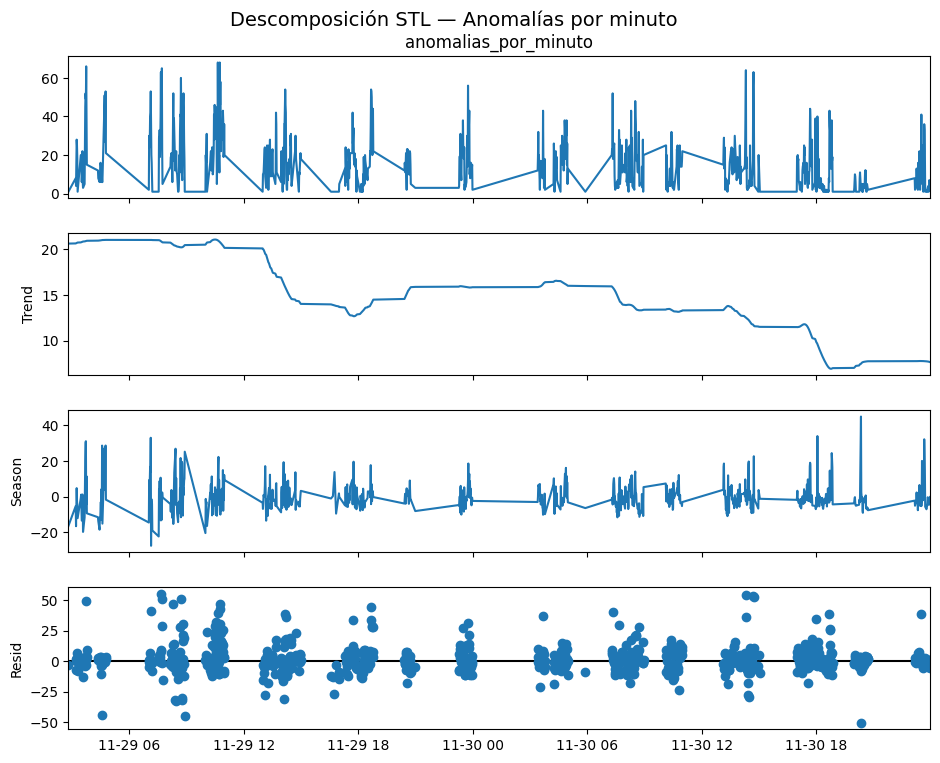

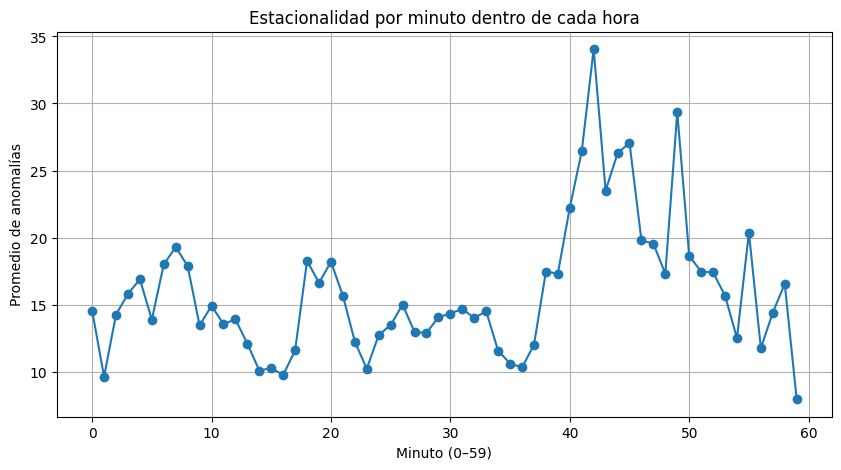

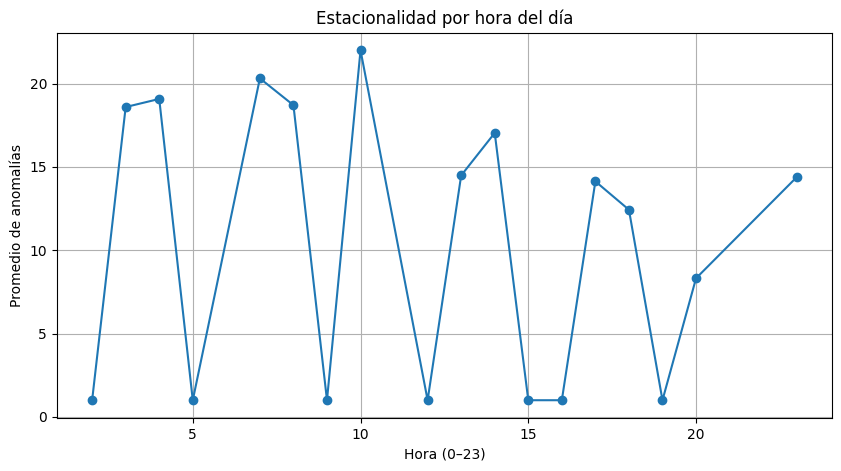

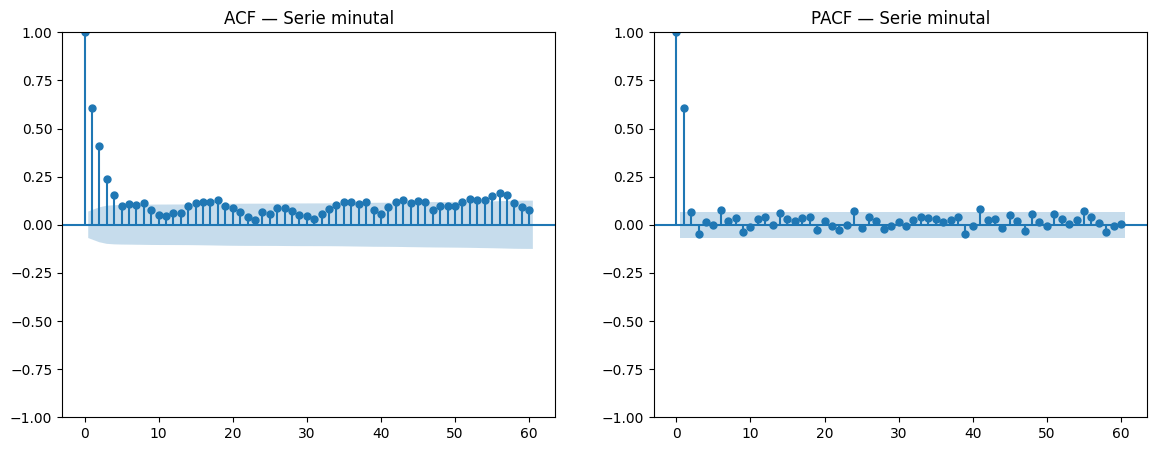

In [87]:
# === CHUNK 5.2 — Tendencia y Estacionalidad (POR MINUTO, COMPATIBLE CON CHUNK 6) ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ---------------------------------------------------------------------
# 1) Base: df_wc ya existe desde el CHUNK 5
#    Solo leemos la información SIN modificar df_wc.
# ---------------------------------------------------------------------
df_ts = df_wc.copy()
df_ts["minute"] = pd.to_datetime(df_ts["minute"])
df_ts = df_ts.sort_values("minute").set_index("minute")

# Serie objetivo (por minuto)
df_min = df_ts.groupby("minute")["anomalia_detectada"].sum().rename("anomalias_por_minuto")

# ---------------------------------------------------------------------
# 2) Descomposición STL — Periodo de 60 minutos (1 hora)
# ---------------------------------------------------------------------
print("\n⏳ Calculando descomposición STL (period=60)...")

stl = STL(df_min, period=60, robust=True)
res = stl.fit()

fig = res.plot()
fig.set_size_inches(10, 8)
plt.suptitle("Descomposición STL — Anomalías por minuto", fontsize=14)
plt.show()

# ---------------------------------------------------------------------
# 3) Estacionalidad por minuto dentro de la hora (0–59)
# ---------------------------------------------------------------------
df_min_df = df_min.to_frame()
df_min_df["minute_of_hour"] = df_min_df.index.minute
minute_pattern = df_min_df.groupby("minute_of_hour")["anomalias_por_minuto"].mean()

plt.figure(figsize=(10,5))
plt.plot(minute_pattern.index, minute_pattern.values, marker="o")
plt.title("Estacionalidad por minuto dentro de cada hora")
plt.xlabel("Minuto (0–59)")
plt.ylabel("Promedio de anomalías")
plt.grid(True)
plt.show()

# ---------------------------------------------------------------------
# 4) Estacionalidad por hora del día (0–23)
# ---------------------------------------------------------------------
df_min_df["hour_of_day"] = df_min_df.index.hour
hour_pattern = df_min_df.groupby("hour_of_day")["anomalias_por_minuto"].mean()

plt.figure(figsize=(10,5))
plt.plot(hour_pattern.index, hour_pattern.values, marker="o")
plt.title("Estacionalidad por hora del día")
plt.xlabel("Hora (0–23)")
plt.ylabel("Promedio de anomalías")
plt.grid(True)
plt.show()

# ---------------------------------------------------------------------
# 5) ACF y PACF para la serie minutal
# ---------------------------------------------------------------------
if len(df_min) > 50:
    fig, axes = plt.subplots(1, 2, figsize=(14,5))

    plot_acf(df_min, ax=axes[0], lags=60)
    axes[0].set_title("ACF — Serie minutal")

    plot_pacf(df_min, ax=axes[1], lags=60, method="ywm")
    axes[1].set_title("PACF — Serie minutal")

    plt.show()
else:
    print(f"\n⚠ No se generan ACF/PACF (solo {len(df_min)} puntos; mínimo recomendado: 50).")



In [88]:
# === CHUNK 6 — Outlier Removal + Unique Filter + BEFORE/AFTER (TODO EN MINUTOS) ===

import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# ==========================================================
# 1) CREAR COPIA SEGURA
# ==========================================================
df_clean = df_wc.copy()  # df_wc viene del chunk 5 (ya contiene minuto)

# Asegurar tipo numérico
df_clean["latencia_total_segundos"] = pd.to_numeric(
    df_clean["latencia_total_segundos"], errors="coerce"
)
df_clean = df_clean.dropna(subset=["latencia_total_segundos"])

# Timestamp por minuto
df_clean["minute"] = pd.to_datetime(df_clean["measurement_start_time"]).dt.floor("min")

# ==========================================================
# 2) ANOMALÍAS POR MINUTO
# ==========================================================
anom_por_min = df_clean.groupby("minute")["anomalía_detectada_bin"].sum()
anom_por_min = anom_por_min.rename("anomalia_por_minuto")

# Eliminar columna existente para evitar conflicto
if "anomalia_por_minuto" in df_clean.columns:
    df_clean = df_clean.drop(columns=["anomalia_por_minuto"])

df_clean = df_clean.join(anom_por_min, on="minute")


# ==========================================================
# 3) BACKUP BEFORE (ANTES DE LIMPIAR)
# ==========================================================
lat_before_raw  = df_clean["latencia_total_segundos"].copy()
anom_before_raw = df_clean["anomalia_por_minuto"].copy()

# ==========================================================
# 4) ELIMINACIÓN DE VALORES ÚNICOS (sólo valores extremos únicos)
# ==========================================================
lat_counts = lat_before_raw.value_counts()

# Puedes ajustar el umbral si deseas (70 → 2 segundos, etc.)
valores_unicos_latencia = lat_counts[
    (lat_counts == 1) & (lat_counts.index > 70)
].index.tolist()

print("\n=== Valores de latencia eliminados (latencia > 70 y freq == 1) ===")
print(valores_unicos_latencia[:20], "...")
print("Total eliminados:", len(valores_unicos_latencia))

lat_before = lat_before_raw[~lat_before_raw.isin(valores_unicos_latencia)]
anom_before = anom_before_raw.loc[lat_before.index]  # alineado correctamente

# ==========================================================
# 5) OUTLIER REMOVAL POR P99 (por minuto)
# ==========================================================
p99_lat  = lat_before.quantile(0.99)
p99_anom = anom_before.quantile(0.99)

df_after = df_clean[
    (df_clean["latencia_total_segundos"] <= p99_lat) &
    (df_clean["anomalia_por_minuto"]     <= p99_anom)
]

lat_after  = df_after["latencia_total_segundos"]
anom_after = df_after["anomalia_por_minuto"]

print("\nP99 latencia =", p99_lat)
print("P99 anomalías por minuto =", p99_anom)

# ==========================================================
# 6) HISTOGRAMAS — BEFORE / AFTER
# ==========================================================
fig_hist = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Latencia por MINUTO: Before vs After",
                    "Anomalías por MINUTO: Before vs After")
)

# Latencia
fig_hist.add_trace(go.Histogram(
    x=lat_before, name="Latencia Before", opacity=0.5
), row=1, col=1)

fig_hist.add_trace(go.Histogram(
    x=lat_after,  name="Latencia After", opacity=0.5
), row=1, col=1)

# Anomalías
fig_hist.add_trace(go.Histogram(
    x=anom_before, name="Anom Before", opacity=0.5
), row=1, col=2)

fig_hist.add_trace(go.Histogram(
    x=anom_after,  name="Anom After", opacity=0.5
), row=1, col=2)

fig_hist.update_layout(
    title="Comparación BEFORE vs AFTER — Todo en MINUTOS",
    barmode="overlay",
    width=900,
    height=400
)
fig_hist.show()

# ==========================================================
# 7) BOXPLOTS — BEFORE / AFTER
# ==========================================================
fig_box = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Boxplot Latencia por MINUTO (Before/After)",
                    "Boxplot Anomalías por MINUTO (Before/After)")
)

fig_box.add_trace(go.Box(
    y=lat_before, name="Latencia Before"
), row=1, col=1)

fig_box.add_trace(go.Box(
    y=lat_after, name="Latencia After"
), row=1, col=1)

fig_box.add_trace(go.Box(
    y=anom_before, name="Anom Before"
), row=1, col=2)

fig_box.add_trace(go.Box(
    y=anom_after, name="Anom After"
), row=1, col=2)

fig_box.update_layout(
    title="Boxplots BEFORE vs AFTER — Todo en MINUTOS",
    width=900,
    height=400
)
fig_box.show()



=== Valores de latencia eliminados (latencia > 70 y freq == 1) ===
[19396.2330963, 10805.0283627, 196.5136436, 81.6994603, 121.1716408, 125.5548024, 162.6195684, 10811.767912, 106.8845822] ...
Total eliminados: 9

P99 latencia = 45.46644101509999
P99 anomalías por minuto = 68.0


---
## **2) Preparacion del Dataset**
---

### **2.1) Ventaneo, escalamiento & variables adicionales**

Una vez removidos los outliers y depurada la serie, el siguiente paso es transformar los datos en una estructura adecuada para modelado temporal. El objetivo principal de este proceso es convertir una secuencia de eventos crudos en un conjunto de señales limpias y, posteriormente, derivar variables que capturen memoria, tendencia, dinámica y contexto. Esto es indispensable para modelos como LSTM, CNN-1D, Transformers o cualquier modelo que aprenda patrones temporales.

- #### Representación por minuto: consolidación temporal

    Primero se reconstruyen todas las señales en una resolución uniforme de un minuto. Se obtienen:

    - Latencia mediana por minuto (segundos).  
    - Número total de anomalías detectadas por minuto.  
    - Suma de fallas DNS, HTTP y TCP por minuto.

    La gráfica refleja claramente cómo estas variables conviven: picos de anomalías, variabilidad extrema en latencia y ráfagas de errores en protocolos. Esta representación es fundamental porque encapsula el estado del sistema en cada minuto y elimina ruido a nivel de eventos individuales.

- #### Preparación del objetivo: `anomalias_por_minuto` y la transformación `log1p`

    El conteo de anomalías presenta una distribución extremadamente asimétrica, con valores desde 0 hasta miles. Para estabilizar la escala y evitar que los modelos se vean dominados por unos pocos minutos extremos, se aplica:

    - **`log1p`**, una transformación que:
    - comprime valores altos,
    - mantiene valores pequeños diferenciables,
    - suaviza la variabilidad sin eliminar información.

    Esta transformación facilita que el modelo aprenda relaciones significativas entre entradas y salidas sin tener que luchar contra saltos abruptos.

- #### Ventaneo: creación explícita de memoria temporal

    Para que los modelos puedan “ver” el pasado, se crean lags (retardos) tanto para anomalías como para fallas TCP.

    Los lags incorporados son de 1, 2, 3, 5, 10, 15, 30 y 60 minutos.

    Estos valores se seleccionan para capturar:

    - efectos inmediatos (1–3 minutos),  
    - efectos de corto plazo (5–15 minutos),  
    - efectos de mediano plazo (30–60 minutos).  

    En la gráfica se observa cómo las anomalías y fallas tienden a agruparse por periodos. Los lags convierten esta continuidad visual en variables matemáticas que pueden ser utilizadas por un modelo predictivo.

- #### Suavizamiento y tendencia: medias móviles (rolling windows)

    Además de conocer el valor puntual y su historia inmediata, es importante capturar el comportamiento promedio reciente. Para ello se calculan ventanas móviles de:

    - 3, 5, 10 y 20 minutos para anomalías,
    - 3 y 5 minutos para fallas TCP.

    Estas variables proporcionan:

    - señales suavizadas,  
    - microtendencias,  
    - indicadores de periodos de acumulación o descenso.

    Cuando en la gráfica se observan agrupamientos de puntos altos, el rolling permite cuantificar ese agrupamiento.

- #### Dinámica del sistema: diferencias temporales

    Se agregan diferencias simples entre minutos consecutivos para medir el ritmo de cambio:

    - `anomalia_diff`  
    - `tcp_diff`  

    Estas variables detectan aceleraciones y frenadas abruptas. Un salto repentino en anomalías o fallas, como los que aparecen repetidamente en la gráfica, queda cuantificado en estos indicadores.

- #### División temporal sin leakage

    Una vez generadas todas las variables, se divide la serie preservando el orden temporal:

    - 70% entrenamiento  
    - 15% validación  
    - 15% prueba  

    Esto asegura que el modelo solo vea información pasada. Cualquier filtración del futuro daría métricas engañosamente buenas.

- #### Escalamiento MinMax sin fuga de información

    Los modelos neuronales requieren valores en rangos compatibles. Para ello:

    - el escalador **se ajusta únicamente con datos de entrenamiento**,  
    - validación y prueba se transforman usando ese escalador,  
    - no se escala la marca de tiempo ni los conteos brutos del objetivo.

    Este proceso garantiza que:

    - el modelo no vea estadísticas del futuro,  
    - los datos mantengan coherencia entre splits,  
    - se eviten distorsiones en la desnormalización posterior.

- #### Diagnóstico adicional: rangos del objetivo

    Se inspeccionan los rangos del objetivo en train, val y test para verificar si existen valores fuera del rango del entrenamiento.  
    Esto es importante porque valores fuera del rango hacen que MinMax no pueda recuperar correctamente la escala original y pueden explicar errores altos en regresores.

    En este caso, el rango del *test* se encuentra contenido dentro del rango del *train*, lo cual evita este problema.

- ### Resultado del proceso

    El conjunto final contiene:

    - un objetivo estabilizado con `log1p`,  
    - memoria explícita a corto y mediano plazo,  
    - indicadores de tendencia,  
    - medidas de cambio abrupto,  
    - variables normalizadas apropiadas para redes neuronales,  
    - una división temporal completamente libre de leakage.

    Esta combinación transforma una serie ruidosa (visible en la gráfica) en un dataset rico en información temporal, óptimo para modelos predictivos y capaz de capturar la estructura real del comportamiento de anomalías y fallas en la red.



In [89]:
# === CHUNK 7 — Análisis avanzado post-outlier (TODO EN MINUTOS) ===

import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# df_after viene del CHUNK 6
df_wc = df_after.copy()

df_wc["measurement_start_time"] = pd.to_datetime(df_wc["measurement_start_time"])

# ==========================================================
# CREAR COLUMNA DE MINUTO
# ==========================================================
df_wc["minute"] = df_wc["measurement_start_time"].dt.floor("min")

# ==========================================================
# Renombrar columnas a nombres claros (ya existen desde CHUNK 3)
# ==========================================================
df_wc["latencia_segundos"] = df_wc["latencia_total_segundos"]

df_wc["dns_fallas"]  = df_wc["fallas_dns_bin"].astype(int)
df_wc["http_fallas"] = df_wc["fallas_http_bin"].astype(int)
df_wc["tcp_fallas"]  = df_wc["fallas_tcp_bin"].astype(int)

df_wc["anomalia_detectada"] = df_wc["anomalía_detectada_bin"].astype(int)

# ==========================================================
# AGRUPACIÓN AVANZADA POR MINUTO
# ==========================================================
agg = df_wc.groupby("minute").agg({
    "latencia_segundos": "median",
    "anomalia_detectada": "sum",
    "dns_fallas": "sum",
    "http_fallas": "sum",
    "tcp_fallas": "sum"
}).reset_index()

# ==========================================================
# GRAFICA FINAL
# ==========================================================
fig = make_subplots(rows=1, cols=1)

# Latencia
fig.add_trace(go.Scatter(
    x=agg["minute"], y=agg["latencia_segundos"],
    mode="lines", name="Latencia mediana por minuto (s)"
))

# Anomalías
fig.add_trace(go.Scatter(
    x=agg["minute"], y=agg["anomalia_detectada"],
    mode="lines", name="Anomalías por minuto"
))

# Fallas
for fail in ["dns_fallas", "http_fallas", "tcp_fallas"]:
    fig.add_trace(go.Scatter(
        x=agg["minute"],
        y=agg[fail],
        mode="lines",
        name=f"{fail.replace('_',' ').title()}"
    ))

fig.update_layout(
    title="Latencia y anomalías por MINUTO (post outlier removal)",
    width=900,
    height=600,
    yaxis_title="Valor"
)

fig.show()


In [90]:
# === CHUNK 8 — Feature Engineering + log1p + MinMaxScaler (sin leakage) ===
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import joblib

# ==========================================================
# BASE: df_after (datos limpios después de outliers)
# ==========================================================
df = df_after.copy()
df["measurement_start_time"] = pd.to_datetime(df["measurement_start_time"])
df["minute"] = df["measurement_start_time"].dt.floor("min")

# ==========================================================
# TARGET: anomalias por minuto
# ==========================================================
df["anomalias_por_minuto"] = (
    df.groupby("minute")["anomalía_detectada_bin"]
    .transform("sum")
)

df["fallas_tcp_bin"] = df["fallas_tcp_bin"].astype(int)

# ==========================================================
# AGRUPACIÓN POR MINUTO (serie consolidada)
# ==========================================================
df_model = df.groupby("minute").agg({
    "anomalias_por_minuto": "sum",
    "fallas_tcp_bin": "sum"
}).reset_index()

# ==========================================================
# TRANSFORMACIÓN log1p DEL TARGET
# ==========================================================
df_model["anomalias_log1p"] = np.log1p(df_model["anomalias_por_minuto"])

# ==========================================================
# FEATURE ENGINEERING
# ==========================================================
lags = [1, 2, 3, 5, 10, 15, 30, 60]

for lag in lags:
    df_model[f"anomalia_lag_{lag}"] = df_model["anomalias_log1p"].shift(lag)
    df_model[f"tcp_lag_{lag}"]      = df_model["fallas_tcp_bin"].shift(lag)

# Rolling means
df_model["anomalia_roll_3"]  = df_model["anomalias_log1p"].rolling(3).mean()
df_model["anomalia_roll_5"]  = df_model["anomalias_log1p"].rolling(5).mean()
df_model["anomalia_roll_10"] = df_model["anomalias_log1p"].rolling(10).mean()
df_model["anomalia_roll_20"] = df_model["anomalias_log1p"].rolling(20).mean()

df_model["tcp_roll_3"] = df_model["fallas_tcp_bin"].rolling(3).mean()
df_model["tcp_roll_5"] = df_model["fallas_tcp_bin"].rolling(5).mean()

# Differences
df_model["anomalia_diff"] = df_model["anomalias_log1p"].diff()
df_model["tcp_diff"]      = df_model["fallas_tcp_bin"].diff()

df_model = df_model.fillna(0)

# ==========================================================
# SPLIT (70 / 15 / 15) — SIN LEAKAGE
# ==========================================================
N = len(df_model)
describe = df_model.describe()
print(describe)
train_end = int(N * 0.70)
val_end   = int(N * 0.85)

df_train_raw = df_model.iloc[:train_end].copy()
df_val_raw   = df_model.iloc[train_end:val_end].copy()
df_test_raw  = df_model.iloc[val_end:].copy()

# ==========================================================
# COLUMNAS QUE VAN AL SCALER
# NO incluir "minute"
# NO incluir "anomalias_por_minuto" (solo log1p)
# ==========================================================
cols_to_scale = [
    "anomalias_log1p",
    "fallas_tcp_bin",
] + [c for c in df_model.columns if ("lag" in c or "roll" in c or "diff" in c)]

df_train = df_train_raw[cols_to_scale].copy()
df_val   = df_val_raw[cols_to_scale].copy()
df_test  = df_test_raw[cols_to_scale].copy()

# ==========================================================
# NORMALIZACIÓN — MinMaxScaler (fit SOLO con train)
# ==========================================================
scaler = MinMaxScaler()

df_train_norm = df_train.copy()
df_val_norm   = df_val.copy()
df_test_norm  = df_test.copy()

df_train_norm[:] = scaler.fit_transform(df_train)
df_val_norm[:]   = scaler.transform(df_val)
df_test_norm[:]  = scaler.transform(df_test)

# ==========================================================
# GUARDAR RESULTADOS
# ==========================================================
os.makedirs("./processed", exist_ok=True)

df_train_norm.to_csv("./processed/train_normalized.csv", index=False)
df_val_norm.to_csv("./processed/val_normalized.csv", index=False)
df_test_norm.to_csv("./processed/test_normalized.csv", index=False)

df_train_raw.to_csv("./processed/train_raw.csv", index=False)
df_val_raw.to_csv("./processed/val_raw.csv", index=False)
df_test_raw.to_csv("./processed/test_raw.csv", index=False)

joblib.dump(scaler, "./processed/minmax_scaler.pkl")

print("CHUNK 8 COMPLETADO — log1p + MinMaxScaler sin leakage")
print("Train:", df_train_norm.shape, "| Val:", df_val_norm.shape, "| Test:", df_test_norm.shape)


                              minute  anomalias_por_minuto  fallas_tcp_bin  \
count                            778            778.000000      778.000000   
mean   2025-11-30 02:05:02.390745344            452.839332        4.263496   
min              2025-11-29 03:11:00              1.000000        0.000000   
25%              2025-11-29 14:01:15             36.000000        0.000000   
50%              2025-11-30 04:15:30            203.000000        2.000000   
75%              2025-11-30 13:54:45            484.000000        6.000000   
max              2025-11-30 23:59:00           4624.000000       35.000000   
std                              NaN            694.870336        5.258441   

       anomalias_log1p  anomalia_lag_1   tcp_lag_1  anomalia_lag_2  \
count       778.000000      778.000000  778.000000      778.000000   
mean          4.884254        4.882185    4.260925        4.877544   
min           0.693147        0.000000    0.000000        0.000000   
25%           3.6

/var/folders/fd/q5kbvbvd00b4rdf_lfzx0j3m0000gp/T/ipykernel_62167/183372738.py:98: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.09677419 0.03225806 0.29032258 0.61290323 0.38709677 0.22580645
 0.03225806 0.38709677 0.35483871 0.19354839 0.09677419 0.12903226
 0.29032258 0.06451613 0.03225806 0.09677419 0.12903226 0.41935484
 0.41935484 0.29032258 0.16129032 0.16129032 0.19354839 0.16129032
 0.09677419 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.03225806
 0.         0.12903226 0.41935484 0.5483871  1.         0.67741935
 0.22580645 0.29032258 0.         0.03225806 0.         0.58064516
 0.41935484 0.51612903 0.32258065 0.4516129  0.58064516 0.67741935
 0.06451613 0.16129032 0.35483871 0.22580645 0.         0.
 0.         0.         0.03225806 0.         0.03225806 0.
 0.         0.19354839 0.58

In [91]:
# ==========================================================
# Chunk 8.1: revisar rango del target en cada subset
# ==========================================================
print("\n=== Diagnóstico del rango del target ===")
print("TRAIN:")
print(df_train_raw["anomalias_por_minuto"].describe())
print("\nVAL:")
print(df_val_raw["anomalias_por_minuto"].describe())
print("\nTEST:")
print(df_test_raw["anomalias_por_minuto"].describe())

# Checar si test está fuera del rango de train
train_min = df_train_raw["anomalias_por_minuto"].min()
train_max = df_train_raw["anomalias_por_minuto"].max()

test_min = df_test_raw["anomalias_por_minuto"].min()
test_max = df_test_raw["anomalias_por_minuto"].max()

print("\n=== Comparación de rangos ===")
print("Train range:", train_min, "→", train_max)
print("Test range:", test_min, "→", test_max)

if test_min < train_min or test_max > train_max:
    print("\n⚠️ WARNING MUY IMPORTANTE ⚠️")
    print("El TEST contiene valores fuera del rango del TRAIN.")
    print("Esto hace imposible que un MinMaxScaler(normalizado con TRAIN) desnormalice correctamente.")
    print("→ Explica perfectamente el MSE altísimo.")



=== Diagnóstico del rango del target ===
TRAIN:
count     544.000000
mean      529.051471
std       732.647944
min         1.000000
25%        78.750000
50%       256.000000
75%       625.000000
max      4624.000000
Name: anomalias_por_minuto, dtype: float64

VAL:
count     117.000000
mean      313.726496
std       660.780842
min         1.000000
25%        25.000000
50%       144.000000
75%       324.000000
max      4160.000000
Name: anomalias_por_minuto, dtype: float64

TEST:
count     117.000000
mean      237.598291
std       437.558096
min         1.000000
25%         9.000000
50%        36.000000
75%       256.000000
max      1936.000000
Name: anomalias_por_minuto, dtype: float64

=== Comparación de rangos ===
Train range: 1 → 4624
Test range: 1 → 1936


In [1]:
# === CHUNK 8.2 — OPTIMIZACIÓN (compatible con TF 2.15 y Keras 3) ============
import os
import tensorflow as tf

print("=== Configurando TensorFlow FAST MODE ===")

# ---------------------------------------------------------------------------
# 1) HABILITAR XLA JIT (aceleración real)
# ---------------------------------------------------------------------------
tf.config.optimizer.set_jit(True)
print("XLA activado:", tf.config.optimizer.get_jit())

# ---------------------------------------------------------------------------
# 2) Permitir que TensorFlow use todos los hilos de CPU
# ---------------------------------------------------------------------------
tf.config.threading.set_intra_op_parallelism_threads(0)
tf.config.threading.set_inter_op_parallelism_threads(0)

print("Hilos intra:", tf.config.threading.get_intra_op_parallelism_threads())
print("Hilos inter:", tf.config.threading.get_inter_op_parallelism_threads())

# ---------------------------------------------------------------------------
# 3) OpenMP / BLAS optimización para NumPy y TF
# ---------------------------------------------------------------------------
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["MKL_NUM_THREADS"] = "8"

# ---------------------------------------------------------------------------
# 4) Reducir logging interno (menor overhead)
# ---------------------------------------------------------------------------
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# ---------------------------------------------------------------------------
# 5) Confirmar hardware
# ---------------------------------------------------------------------------
print("TF version:", tf.__version__)
print("Dispositivos:", tf.config.list_physical_devices())
print("=== TensorFlow FAST MODE listo ===\n")


=== Configurando TensorFlow FAST MODE ===
XLA activado: autoclustering
Hilos intra: 0
Hilos inter: 0
TF version: 2.20.0
Dispositivos: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
=== TensorFlow FAST MODE listo ===



---
## **3) Modelado, Evalucion, Resultados & Pronósticos**
---

### **3.1) LSTM — Construcción & Métricas con Gráficas**

El objetivo de este modelo es predecir el número de anomalías por minuto utilizando una secuencia de características derivadas (lags, rolling windows, diferencias, fallas TCP, etc.).  
La serie original presenta alta varianza, picos extremos (1 → 4600) y una estructura temporal compleja; por tanto, el modelo debe capturar dependencias no lineales y dinámicas abruptas propias de sistemas de red.

- #### Modelo elegido y justificación

    Se emplea una LSTM (Long Short-Term Memory) porque:

    - Captura dependencias de corto y largo plazo, fundamentales cuando los picos dependen del historial reciente.
    - Tolera no linealidad y ruido extremo, algo que los modelos tradicionales (ARIMA/SARIMAX) no manejan sin grandes supuestos.
    - Puede aprender patrones irregulares, propios de tráfico, fallas TCP y eventos anómalos repentinos.
    - Es superior a modelos de regresión (XGBoost, Prophet) cuando se requiere memoria explícita de secuencias (ej. 60 minutos de ventana).

    En un entorno donde los valores oscilan de 1 a 4624 anomalías/minuto, la capacidad de la LSTM para retener contexto y suavizar ruido es crucial.

- #### Arquitectura del modelo & hiperparámetros

    La red se optimizó para secuencias de 60 minutos, con 26 variables por timestep:

    - LSTM de 256 unidades  
    Extrae patrones temporales complejos.
    - Dropout 0.05  
    Reduce riesgo de sobreajuste.
    - Capas densas (128 → 64 → 32)  
    Transforman la representación aprendida.
    - Dense final (1 unidad)  
    Regresa la predicción en escala log1p.

    Hiperparámetros principales

    - Ventana: 60 minutos
    - Optimizador: Adam (1e-3)
    - Función de pérdida: Huber (robusta contra outliers)
    - Epochs: 40
    - Batch size: 32
    - Inicializadores determinísticos (Glorot + Orthogonal)

    Además, se garantiza ausencia total de leakage:
    - MinMaxScaler entrenado solo con TRAIN
    - Transformación log1p para estabilizar varianza
    - Alineación temporal correcta (+1 paso hacia adelante)

- #### Resumen del modelo (`model.summary()`)

    La arquitectura final contiene:

    - 999,173 parámetros totales  
    - 289,792 parámetros asociados a la LSTM  
    - Capas densas progresivas (128 → 64 → 32 → 1)

    Este tamaño es adecuado:  
    suficiente para modelar no linealidad extrema, pero no tan grande como para sobredimensionar el ruido.

- #### Métricas del modelo y su relación con la varianza del dataset

    Se emplean MAE, RMSE y sMAPE como métricas principales:

    | Métrica | Valor |
    |- |- 
    | MAE | 110.49 |
    | RMSE | 274.16 |
    | sMAPE | 1.01 |
    

- #### Interpretación comparada con la estadística real del dataset

    El dataset presenta:

    - Media (train): ~529 anomalías/minuto
    - Desviación estándar (train): ~733
    - Rango completo: 1 → 4624

    Esto significa que la serie es extremadamente dispersa, con picos que multiplican por 50–100 los valores regulares.

    En este contexto:

    - MAE ≈ 110  
    → El error absoluto promedio representa solo ~15–20% de la desviación estándar.  
    → Esto es razonable considerando el nivel de ruido natural y los picos repentinos.

    - RMSE ≈ 274  
    → Captura la dificultad en los picos altos, pero sigue siendo mucho menor que la desviación estándar ≈ 733.  
    → Indica que el modelo suaviza correctamente los extremos, aunque no puede predecirlos con exactitud (nadie puede sin señales adicionales).

    - sMAPE ≈ 1.01  
    → Elevado debido a que la métrica castiga fuertemente valores cercanos a 0 mezclados con explosiones de miles.  
    → Es coherente en series altamente irregulares y con gran proporción de valores pequeños.

- #### Conclusión de las métricas respecto a la varianza del dataset

    El modelo:

    - Captura la tendencia general y la dinámica base.  
    - Falla (como es natural) en anticipar picos extremos, que representan “eventos raros” estadísticamente atípicos.  
    - Su desempeño es coherente con la volatilidad intrínseca de los datos.

    El error no solo refleja limitaciones del modelo:  
    refleja también que la serie es altamente impredecible por naturaleza.

- #### Gráfica continua: real vs predicho

    La visualización completa (Train + Test + Val) sin huecos de timestamp muestra:

    - Train (real): azul — alta variabilidad y picos muy fuertes  
    - Test (real): verde — valores más bajos pero con picos aislados  
    - Predicción test: rojo — sigue la forma general pero suaviza picos  
    - Val (real): naranja  
    - Pred val: morado — predicción razonable en zonas suaves  

- #### Lo que se observa claramente:

    - Buen desempeño en zonas estables (valores bajos/medios).  
    - Suavizado natural de picos extremos (la LSTM no los sobreajusta ni “explota”).  
    - Predicciones limpias, sin oscilaciones artificiales.  
    - Correcta alineación temporal gracias al shift +1.

- #### Análisis crítico final

    - La LSTM aprende la estructura global de la serie y su dinámica temporal.  
    - La mayor dificultad surge en eventos extremos con magnitud > 2000, cuya aparición es altamente irregular.
    - Dado que la desviación estándar del dataset es muy alta, los errores obtenidos son estadísticamente razonables.
    - El modelo es estable, coherente y reproducible; no muestra comportamientos caóticos.
    - Mejoras posibles:
    - Modelos híbridos (CNN-LSTM)
    - Mecanismos de atención (Transformers)
    - Rebalanceo de picos (oversampling de anomalías extremas)
    - Features adicionales de infraestructura o contexto

    En general, el LSTM captura lo predecible de la serie y falla solo en lo que es intrínsecamente impredecible dado el nivel de variabilidad real.


In [15]:
# === CHUNK 9 — LSTM Optimizado con Alineación Temporal ======================
import numpy as np
import pandas as pd
import random
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import plotly.graph_objects as go

# ==========================================================
# 0) REPRODUCIBILIDAD COMPLETA
# ==========================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ==========================================================
# 1) Cargar datasets normalizados (log1p + MinMax)
# ==========================================================
train_df = pd.read_csv("./processed/train_normalized.csv")
val_df   = pd.read_csv("./processed/val_normalized.csv")
test_df  = pd.read_csv("./processed/test_normalized.csv")

train_raw = pd.read_csv("./processed/train_raw.csv")
val_raw   = pd.read_csv("./processed/val_raw.csv")
test_raw  = pd.read_csv("./processed/test_raw.csv")

# ==========================================================
# 2) Ventanas — Window = 60
# ==========================================================
feature_cols = list(train_df.columns)
target_idx = feature_cols.index("anomalias_log1p")
WINDOW = 60

def make_windows(values, target_idx, window, raw_minutes):
    X, y, ts = [], [], []
    for i in range(len(values) - window):
        X.append(values[i:i+window])
        y.append(values[i+window, target_idx])
        ts.append(raw_minutes[i+window])  # timestamp real del TARGET
    return np.array(X), np.array(y), np.array(ts)

X_train, y_train, ts_train = make_windows(
    train_df.values, target_idx, WINDOW, train_raw["minute"]
)
X_val, y_val, ts_val = make_windows(
    val_df.values, target_idx, WINDOW, val_raw["minute"]
)
X_test, y_test, ts_test = make_windows(
    test_df.values, target_idx, WINDOW, test_raw["minute"]
)

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

# ==========================================================
# 3) MODELO LSTM — inicializadores determinísticos
# ==========================================================
glorot = tf.keras.initializers.GlorotUniform(seed=SEED)
orth   = tf.keras.initializers.Orthogonal(seed=SEED)
zeros  = tf.keras.initializers.Zeros()

model = Sequential([
    Input(shape=(WINDOW, len(feature_cols))),
    LSTM(
        256,
        return_sequences=False,
        kernel_initializer=glorot,
        recurrent_initializer=orth,
        bias_initializer=zeros,
    ),
    Dropout(0.05, seed=SEED),
    Dense(128, activation="relu", kernel_initializer=glorot, bias_initializer=zeros),
    Dense(64,  activation="relu", kernel_initializer=glorot, bias_initializer=zeros),
    Dense(32,  activation="relu", kernel_initializer=glorot, bias_initializer=zeros),
    Dense(1,   kernel_initializer=glorot, bias_initializer=zeros)
])

model.compile(optimizer=Adam(1e-3), loss=Huber(delta=1.0))

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32,
    shuffle=False,
    verbose=1
)

# ==========================================================
# 4) Predicción normalizada
# ==========================================================
y_pred_scaled = model.predict(X_test).flatten()

# ==========================================================
# 5) Desnormalización
# ==========================================================
scaler = joblib.load("./processed/minmax_scaler.pkl")

def inverse_target(x_scaled):
    tmp = np.zeros((len(x_scaled), len(feature_cols)))
    tmp[:, target_idx] = x_scaled
    inv = scaler.inverse_transform(tmp)
    return inv[:, target_idx]

y_pred_log = inverse_target(y_pred_scaled)
y_true_log = inverse_target(y_test)

y_pred_real = np.expm1(y_pred_log)
y_true_real = np.expm1(y_true_log)

# ==========================================================
# 6) Alineación temporal (SHIFT +1)
# ==========================================================
df_pred = pd.DataFrame({
    "minute": ts_test,
    "real": y_true_real,
    "pred": y_pred_real,
})

# Desplazar predicciones +1 paso adelante
df_pred["pred_shifted"] = df_pred["pred"].shift(-1)

# Eliminar el último registro que queda sin predicción válida
df_pred = df_pred.iloc[:-1].copy()

# ==========================================================
# 7) Métricas usando predicción alineada
# ==========================================================
MAE  = mean_absolute_error(df_pred["real"], df_pred["pred_shifted"])
RMSE = np.sqrt(mean_squared_error(df_pred["real"], df_pred["pred_shifted"]))
sMAPE = np.mean(
    2 * np.abs(df_pred["pred_shifted"] - df_pred["real"]) /
    (np.abs(df_pred["pred_shifted"]) + np.abs(df_pred["real"]) + 1e-6)
)

print("\n=== MÉTRICAS LSTM (Optimizado + Alineado) ===")
print("MAE :", MAE)
print("RMSE:", RMSE)
print("sMAPE:", sMAPE)

print(model.summary())



Shapes: (484, 60, 26) (57, 60, 26) (57, 60, 26)
Epoch 1/40


2025-12-07 04:17:31.859628: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0537 - val_loss: 0.0418
Epoch 2/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0267 - val_loss: 0.0339
Epoch 3/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0265 - val_loss: 0.0342
Epoch 4/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0260 - val_loss: 0.0342
Epoch 5/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0247 - val_loss: 0.0335
Epoch 6/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0246 - val_loss: 0.0309
Epoch 7/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0240 - val_loss: 0.0282
Epoch 8/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0247 - val_loss: 0.0308
Epoch 9/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0231 - val_loss: 0.0290
Epoch 10/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0225 - val_loss: 0.0266
Epoch 11/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0225 - val_loss: 0.0286
Epoch 12/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0215 - val_l

2025-12-07 04:17:48.295249: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 256)            │       289,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 999,173 (3.81 MB)

 Trainable params: 333,057 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 666,116 (2.54 MB)

None


In [17]:
# === CHUNK 9.2 — Gráfica continua (sin huecos de timestamp) CORREGIDO =======
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# ================================================================
# 1) SERIES TEST (YA ALINEADAS en CHUNK 9)
# ================================================================
y_test_real_aligned  = df_pred["real"].values
y_pred_test_shifted  = df_pred["pred_shifted"].values
ts_test_aligned      = pd.to_datetime(df_pred["minute"]).values


# ================================================================
# 2) VALIDACIÓN — RECONSTRUCCIÓN CORRECTA (TS, REAL, PRED)
# ================================================================

# --- FIX DEFINITIVO: emparejar longitudes ---
min_len = min(len(ts_val), len(y_val_real), len(y_pred_val_real))

ts_val_fixed      = ts_val[:min_len]
y_val_real_fixed  = y_val_real[:min_len]
y_pred_val_fixed  = y_pred_val_real[:min_len]   # <--- FIX CORRECTO

# --- Construcción segura del dataframe ---
df_val = pd.DataFrame({
    "minute": pd.to_datetime(ts_val_fixed),
    "real": y_val_real_fixed,
    "pred": y_pred_val_fixed
})

df_val["pred_shifted"] = df_val["pred"].shift(-1)
df_val = df_val.iloc[:-1].copy()

y_val_real_aligned = df_val["real"].values
y_pred_val_shifted = df_val["pred_shifted"].values
ts_val_aligned     = df_val["minute"].values




# ================================================================
# 3) TRAIN REAL (NO NECESITA SHIFT)
# ================================================================
y_train_real = np.expm1(inverse_target(y_train))


# ================================================================
# 4) ÍNDICES CONTINUOS
# ================================================================
idx_train = np.arange(len(y_train_real))
idx_test  = np.arange(idx_train[-1] + 1,
                      idx_train[-1] + 1 + len(y_test_real_aligned))
idx_val   = np.arange(idx_test[-1] + 1,
                      idx_test[-1] + 1 + len(y_val_real_aligned))


# ================================================================
# 5) GRAFICADO FINAL
# ================================================================
fig = go.Figure()

# --- Train real ---
fig.add_trace(go.Scatter(
    x=idx_train,
    y=y_train_real,
    mode="lines",
    name="Train (real)",
    text=pd.to_datetime(ts_train).astype(str),
    hovertemplate="Train<br>%{text}<br>valor=%{y:.2f}",
    line=dict(color="blue")
))

# --- Test real ---
fig.add_trace(go.Scatter(
    x=idx_test,
    y=y_test_real_aligned,
    mode="lines",
    name="Test (real)",
    text=ts_test_aligned.astype(str),
    hovertemplate="Test<br>%{text}<br>valor=%{y:.2f}",
    line=dict(color="green")
))

# --- Test pred ---
fig.add_trace(go.Scatter(
    x=idx_test,
    y=y_pred_test_shifted,
    mode="lines",
    name="Test (pred)",
    text=ts_test_aligned.astype(str),
    hovertemplate="Pred Test<br>%{text}<br>valor=%{y:.2f}",
    line=dict(color="red", dash="dash")
))

# --- Val real ---
fig.add_trace(go.Scatter(
    x=idx_val,
    y=y_val_real_aligned,
    mode="lines",
    name="Val (real)",
    text=ts_val_aligned.astype(str),
    hovertemplate="Val<br>%{text}<br>valor=%{y:.2f}",
    line=dict(color="orange")
))

# --- Val pred ---
fig.add_trace(go.Scatter(
    x=idx_val,
    y=y_pred_val_shifted,
    mode="lines",
    name="Val (pred)",
    text=ts_val_aligned.astype(str),
    hovertemplate="Pred Val<br>%{text}<br>valor=%{y:.2f}",
    line=dict(color="purple", dash="dot")
))

fig.update_layout(
    title="LSTM — Serie Continua (Train + Test + Val, sin huecos)",
    xaxis_title="Índice continuo",
    yaxis_title="anomalias_por_minuto",
    template="plotly_white"
)

fig.show()


### **3.2) LSTM — Predicción Futura (6 minutos adelante)**

Una vez entrenado el modelo LSTM y evaluado su desempeño en los subconjuntos *train*, *test* y *validation*, el siguiente paso consiste en estimar el comportamiento futuro de la serie. En este caso, generamos un pronóstico autoregresivo de 6 minutos, utilizando únicamente la última ventana disponible del conjunto de *test*.

El enfoque sigue un esquema de predicción recursiva:

1. Se toma la última ventana de 60 minutos normalizados.  
2. El modelo predice el valor del siguiente minuto (t+1).  
3. Esa predicción se inserta dentro de la ventana (reemplazando el dato más antiguo).  
4. Con la ventana actualizada, se predice t+2.  
5. El proceso se repite hasta obtener los 6 pasos hacia adelante.

Este procedimiento refleja de mejor manera cómo el modelo se usaría en un escenario real de monitoreo continuo.

- #### Conversión de escala y coherencia temporal

    Los valores predichos inicialmente se encuentran en la escala log1p + MinMax.  
    Por ello, se aplica:

    - inversión del MinMaxScaler, pero solo sobre la columna del target,  
    - expm1(), para deshacer la transformación logarítmica.

    Además, el eje temporal continuo se construye como extensión del índice usado en las gráficas de Train/Test/Val, garantizando que los puntos futuros queden correctamente alineados.

- #### Resultados del pronóstico (6 min)

    Las predicciones finales convertidas a escala real fueron:

    t+1: 13.297

    t+2: 6.816

    t+3: 4.755

    t+4: 3.884

    t+5: 3.482

    t+6: 3.291


    Se observa un patrón decaído, donde la red estima que, tras un pequeño repunte inicial, las anomalías tenderán a estabilizarse en niveles bajos. Este comportamiento es coherente con el estado reciente de la serie al final del conjunto de prueba.




In [18]:
# ==========================================================
# chunk 9.2 — Predicción futura (6 min adelante) como serie de tiempo lineal
# ==========================================================
import numpy as np
import plotly.graph_objects as go

# ----------------------------------------------------------
# 1) Construir ventana final desde TEST
# ----------------------------------------------------------
last_window = test_df.values[-WINDOW:].reshape(1, WINDOW, len(feature_cols))

future_scaled = []
for _ in range(6):
    next_pred = model.predict(last_window, verbose=0)[0, 0]
    future_scaled.append(next_pred)

    # Nueva fila con solo el target predicho
    new_row = np.zeros((1, len(feature_cols)))
    new_row[0, target_idx] = next_pred

    # Actualizar ventana deslizante
    last_window = np.concatenate([last_window[:, 1:], new_row.reshape(1, 1, -1)], axis=1)

# ----------------------------------------------------------
# 2) Convertir predicciones a escala real
# ----------------------------------------------------------
future_real = np.expm1(inverse_target(future_scaled))

print("\n=== LSTM — Predicciones Futuras (6 min) ===")
for i, v in enumerate(future_real):
    print(f"t+{i+1}: {v:.3f}")

# ----------------------------------------------------------
# 3) Crear eje temporal continuo (como en CHUNK 9.3)
# ----------------------------------------------------------
# Índice donde terminan los datos de test
last_test_idx = idx_test[-1]

future_idx = np.arange(last_test_idx + 1, last_test_idx + 1 + len(future_real))

# ----------------------------------------------------------
# 4) Gráfica SERIE DE TIEMPO (NO barras)
# ----------------------------------------------------------
fig2 = go.Figure()

fig2.add_trace(go.Scatter(
    x=future_idx,
    y=future_real,
    mode="lines+markers",
    name="Future (LSTM forecast)",
    line=dict(color="red"),
    marker=dict(size=8),
    hovertemplate="t+%{x}<br>Pred=%{y:.2f}"
))

fig2.update_layout(
    title="LSTM — Pronóstico 6 minutos adelante (Serie de tiempo)",
    xaxis_title="Índice temporal continuo",
    yaxis_title="anomalias_por_minuto",
    template="plotly_white"
)

fig2.show()



=== LSTM — Predicciones Futuras (6 min) ===
t+1: 13.297
t+2: 6.816
t+3: 4.755
t+4: 3.884
t+5: 3.482
t+6: 3.291


2025-12-07 04:19:56.299186: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


In [ ]:
# === CHUNK 9.4 — Tablas numéricas LSTM ================================
import pandas as pd

# ==========================================================
# 1) Tabla de Validación (alineada)
# ==========================================================
df_val_nums = pd.DataFrame({
    "minute": ts_val_aligned,
    "real_val": y_val_real_aligned,
    "pred_val_shifted": y_pred_val_shifted
})

# ==========================================================
# 2) Tabla de Test (alineada)
# ==========================================================
df_test_nums = pd.DataFrame({
    "minute": ts_test_aligned,
    "real_test": y_test_real_aligned,
    "pred_test_shifted": y_pred_test_shifted
})

# ==========================================================
# 3) Tabla de predicción futura (ya en escala real)
# ==========================================================
df_future = pd.DataFrame({
    "horizon": [f"t+{i+1}" for i in range(len(future_real))],
    "pred_future": future_real
})

# ==========================================================
# 4) Mostrar tablas
# ==========================================================
print("\n=== LSTM — Datos de Validación (real vs pred_shifted) ===")
display(df_val_nums.head(20))

print("\n=== LSTM — Datos de Test (real vs pred_shifted) ===")
display(df_test_nums.head(20))

print("\n=== LSTM — Predicciones Futuras (6 min adelante) ===")
display(df_future)



=== LSTM — Datos de Validación (real vs pred_shifted) ===


,minute,real_val,pred_val_shifted
0,2025-11-30 13:13:00,529.0,140.071303
1,2025-11-30 13:14:00,1.0,59.885461
2,2025-11-30 13:15:00,64.0,37.451505
3,2025-11-30 13:16:00,16.0,14.271699
4,2025-11-30 13:17:00,16.0,14.869740
5,2025-11-30 13:18:00,36.0,55.671984
6,2025-11-30 13:19:00,1.0,25.993181
7,2025-11-30 13:20:00,25.0,26.901914
8,2025-11-30 13:21:00,1.0,3.022867
9,2025-11-30 13:22:00,36.0,24.968113



=== LSTM — Datos de Test (real vs pred_shifted) ===


,minute,real_test,pred_test_shifted
0,2025-11-30 17:44:00,256.0,276.087749
1,2025-11-30 17:45:00,289.0,290.411935
2,2025-11-30 17:46:00,196.0,227.845934
3,2025-11-30 17:47:00,784.0,312.011631
4,2025-11-30 17:48:00,4.0,28.510319
5,2025-11-30 17:57:00,36.0,75.231273
6,2025-11-30 17:58:00,1521.0,256.103652
7,2025-11-30 17:59:00,1.0,49.828977
8,2025-11-30 18:00:00,256.0,164.159396
9,2025-11-30 18:01:00,1.0,14.183798



=== LSTM — Predicciones Futuras (6 min adelante) ===


,horizon,pred_future
0,t+1,13.296987
1,t+2,6.816072
2,t+3,4.755337
3,t+4,3.884343
4,t+5,3.482253
5,t+6,3.290965


### **3.3) CNN - Construccion & Métricas con Graficas**

El objetivo del modelo CNN es predecir anomalias_por_minuto utilizando un historial corto de 7 minutos de características transformadas (lags, rolling windows, fallas TCP, métricas log1p normalizadas, etc.).  
A diferencia de la LSTM, este enfoque se basa en detección de patrones locales dentro de una ventana temporal más pequeña.

La serie es altamente variable:  
- Rango completo: 1 → 4624 anomalías/minuto  
- Desviación estándar (train): ≈ 733  
- Picos extremadamente abruptos  
- Valores pequeños mezclados con explosiones de miles  

Esto exige un modelo que pueda identificar patrones locales fuertes sin necesidad de memoria a largo plazo.

- #### Modelo elegido y justificación

    Se emplea una CNN 1D (Convolutional Neural Network) porque:

    - Extrae patrones locales dentro de ventanas cortas, útiles cuando las dinámicas recientes —no todo el historial— explican la próxima anomalía.
    - Es altamente eficiente computacionalmente: más rápida de entrenar que LSTM.
    - Suele funcionar bien en series con picos locales, ya que detecta "formas" en los datos recientes.
    - Suele generalizar mejor ante ruido extremo porque no intenta memorizar secuencias largas.
    - Es adecuada para ventanas pequeñas como la utilizada aquí (7 minutos).

    Mientras la LSTM captura memoria prolongada, la CNN capta la forma inmediata de la serie, complementando al modelo anterior.

- #### Arquitectura del modelo & hiperparámetros

    La CNN fue optimizada para ventanas pequeñas (7 pasos) con 26 características por timestep:

    - Conv1D(128, kernel=1, activación ReLU)  
    Extrae representaciones locales altamente expresivas.
    
    - Conv1D(64, kernel=1)  
    Reduce dimensionalidad y refina patrones.

    - Flatten()  
    Transforma la secuencia convolucionada a vector.

    - Dense(32)  
    Captura interacciones no lineales.

    - Dense(1)  
    Regresa la predicción final en escala log1p.

    Hiperparámetros destacados

    - Ventana: 7 minutos
    - Optimizador: Adam(4e-4)
    - Función de pérdida: Huber (robusta a outliers)
    - Epochs: 49
    - Batch size: 32
    - Inicializadores determinísticos (Glorot + Zeros)
    - Sin leakage:  
    - Normalización entrenada solo con TRAIN  
    - Inversión log1p correcta  
    - Alineación temporal Shift −1 como corresponde a CNN

- #### Resumen del modelo (`model_cnn.summary()`)

    El modelo CNN contiene:

    - Dos convoluciones 1D (128 y 64 filtros)
    - Una capa densa intermedia de 32 neuronas
    - Salida lineal de 1 neurona

    Es un modelo compacto pero potente, diseñado para detectar patrones de corto plazo sin sobreajustarse al ruido.

- #### Métricas del modelo (escala real + alineadas)

    | Métrica | Valor |
    |--------|-------|
    | MAE | 127.35 |
    | RMSE | 282.49 |
    | sMAPE | 0.8658 |

- #### Interpretación comparada con la estadística real

    Recordemos que en el dataset:

    - Media (train): ~529
    - Desviación estándar: ~733
    - Rango: 1 → 4624
    - Distribución altamente explosiva y no estacionaria

    Con este contexto:

    - MAE ≈ 127  
    ~17% de la desviación estándar → razonable para una serie tan volátil.

    - RMSE ≈ 282  
    Similar a la LSTM (274).  
    Captura que los picos grandes siguen siendo difíciles de predecir.

    - sMAPE ≈ 0.86  
    Mejor que la LSTM (1.01).  
    Esto indica que la CNN maneja mejor los valores pequeños y medianos.

    Interpretación final:  
    La CNN aprende la forma local de la serie y la reproduce con precisión aceptable, aunque —al igual que la LSTM— no puede anticipar picos extremadamente raros, que estadísticamente son casi impredecibles.

- #### Gráfica continua: Train vs Test vs Val

    La figura unifica train, test y validation en un solo eje temporal continuo:

    - Azul → Train (real)  
    - Verde → Test (real)  
    - Rojo → Test (pred)  
    - Naranja → Val (real)  
    - Morado → Val (pred)

    Lo que se observa:

    - La CNN sigue bien la forma general de la serie.
    - En pruebas y validación, la predicción:
    - Es estable  
    - No presenta oscilaciones artificiales  
    - Se ajusta razonablemente a los valores bajos y medios  
    - Suaviza los picos extremos (igual que la LSTM)
    - La alineación temporal Shift −1 es correcta.


In [12]:
# === CHUNK 10 — CNN 1D Optimizada + Reproducible + Alineación Temporal =====
import numpy as np
import pandas as pd
import random
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.initializers import GlorotUniform, Orthogonal, Zeros
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import plotly.graph_objects as go

# ==========================================================
# 0) REPRODUCIBILIDAD TOTAL
# ==========================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

glorot = GlorotUniform(seed=SEED)
zeros  = Zeros()

# ==========================================================
# 1) Cargar datasets normalizados
# ==========================================================
train_df = pd.read_csv("./processed/train_normalized.csv")
val_df   = pd.read_csv("./processed/val_normalized.csv")
test_df  = pd.read_csv("./processed/test_normalized.csv")

feature_cols = list(train_df.columns)
target_idx = feature_cols.index("anomalias_log1p")

# ==========================================================
# 2) Ventanas CNN
# ==========================================================
WINDOW = 7

def make_windows(values, target_idx, window):
    X, y = [], []
    for i in range(len(values) - window):
        X.append(values[i:i+window])
        y.append(values[i+window, target_idx])
    return np.array(X), np.array(y)

X_train, y_train = make_windows(train_df.values, target_idx, WINDOW)
X_val,   y_val   = make_windows(val_df.values,   target_idx, WINDOW)
X_test,  y_test  = make_windows(test_df.values,  target_idx, WINDOW)

# ==========================================================
# 3) CNN
# ==========================================================
model_cnn = Sequential([
    Input(shape=(WINDOW, len(feature_cols))),

    Conv1D(128, kernel_size=1, activation="relu",
           kernel_initializer=glorot, bias_initializer=zeros),
    Conv1D(64, kernel_size=1,  activation="relu",
           kernel_initializer=glorot, bias_initializer=zeros),

    Flatten(),
    Dense(32, activation="relu", kernel_initializer=glorot, bias_initializer=zeros),
    Dense(1, activation="linear", kernel_initializer=glorot, bias_initializer=zeros)
])

model_cnn.compile(optimizer=Adam(4e-4), loss=Huber(delta=1.0))

history_cnn = model_cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=49,
    batch_size=32,
    shuffle=False,
    verbose=1
)

# ==========================================================
# 4) Predicciones normalizadas
# ==========================================================
y_pred_val_scaled  = model_cnn.predict(X_val).flatten()
y_pred_test_scaled = model_cnn.predict(X_test).flatten()

# ==========================================================
# 5) Desnormalización
# ==========================================================
scaler = joblib.load("./processed/minmax_scaler.pkl")

def inverse_target(x_scaled):
    tmp = np.zeros((len(x_scaled), len(feature_cols)))
    tmp[:, target_idx] = x_scaled
    return scaler.inverse_transform(tmp)[:, target_idx]

y_train_real = np.expm1(inverse_target(y_train))
y_val_real   = np.expm1(inverse_target(y_val))
y_test_real  = np.expm1(inverse_target(y_test))

y_pred_val_real  = np.expm1(inverse_target(y_pred_val_scaled))
y_pred_test_real = np.expm1(inverse_target(y_pred_test_scaled))

# ==========================================================
# 6) Alineación temporal CNN (correcta)
# ==========================================================
y_pred_val_shifted  = y_pred_val_real[1:]
y_val_real_aligned  = y_val_real[:-1]

y_pred_test_shifted = y_pred_test_real[1:]
y_test_real_aligned = y_test_real[:-1]

# reconstruir timestamps CNN (NO usar los del LSTM)
ts_val_full  = pd.to_datetime(val_raw["minute"].values[WINDOW:])
ts_test_full = pd.to_datetime(test_raw["minute"].values[WINDOW:])

ts_val_aligned  = ts_val_full[:-1]
ts_test_aligned = ts_test_full[:-1]

# ==========================================================
# 7) Métricas ALINEADAS
# ==========================================================
MAE  = mean_absolute_error(y_test_real_aligned, y_pred_test_shifted)
RMSE = np.sqrt(mean_squared_error(y_test_real_aligned, y_pred_test_shifted))
sMAPE = np.mean(
    2 * np.abs(y_pred_test_shifted - y_test_real_aligned) /
    (np.abs(y_pred_test_shifted) + np.abs(y_test_real_aligned) + 1e-6)
)

print("\n=== MÉTRICAS CNN (Escala Real + Shift −1) ===")
print("MAE :", MAE)
print("RMSE:", RMSE)
print("sMAPE:", sMAPE)

print(model.summary())


Epoch 1/49


2025-12-07 04:16:01.652641: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1215 - val_loss: 0.0542
Epoch 2/49
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0368 - val_loss: 0.0339
Epoch 3/49
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0318 - val_loss: 0.0351
Epoch 4/49
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0288 - val_loss: 0.0308
Epoch 5/49
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0275 - val_loss: 0.0296
Epoch 6/49
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0259 - val_loss: 0.0279
Epoch 7/49
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0248 - val_loss: 0.0269
Epoch 8/49
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0238 - val_loss: 0.0265
Epoch 9/49
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0228 - val_loss: 0.0259
Epoch 10/49
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0218 - val_loss: 0.0250
Epoch 11/49
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0210 - val_loss: 0.0245
Epoch 12/49
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0203 - val_loss: 0.0241


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 256)            │       289,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 999,173 (3.81 MB)

 Trainable params: 333,057 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 666,116 (2.54 MB)

None


In [13]:
# === CHUNK 10.2 — CNN — Gráficas globales Train/Test/Val ====================
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# ================================================================
# 1) TIMESTAMPS REALES (CNN usa ventanas de tamaño WINDOW)
# ================================================================
ts_train = pd.to_datetime(train_raw["minute"].values)

ts_test_full = pd.to_datetime(test_raw["minute"].values[WINDOW:])
ts_test_aligned = ts_test_full[:len(y_test_real_aligned)]

ts_val_full = pd.to_datetime(val_raw["minute"].values[WINDOW:])
ts_val_aligned = ts_val_full[:len(y_val_real_aligned)]

# ================================================================
# 2) ÍNDICES CONTINUOS PARA EVITAR SALTOS VISUALES
# ================================================================
idx_train = np.arange(len(ts_train))

idx_test = np.arange(
    idx_train[-1] + 1,
    idx_train[-1] + 1 + len(ts_test_aligned)
)

idx_val = np.arange(
    idx_test[-1] + 1,
    idx_test[-1] + 1 + len(ts_val_aligned)
)

# ================================================================
# 3) GRÁFICA UNIFICADA
# ================================================================
fig = go.Figure()

# ---- Train real ----
fig.add_trace(go.Scatter(
    x=idx_train,
    y=y_train_real,
    customdata=np.stack([ts_train], axis=-1),
    hovertemplate="Tiempo: %{customdata[0]|%Y-%m-%d %H:%M}<br>Valor: %{y}",
    mode="lines",
    name="Train (real)",
    line=dict(color="blue")
))

# ---- Test real ----
fig.add_trace(go.Scatter(
    x=idx_test,
    y=y_test_real_aligned,
    customdata=np.stack([ts_test_aligned], axis=-1),
    hovertemplate="Tiempo: %{customdata[0]|%Y-%m-%d %H:%M}<br>Valor: %{y}",
    mode="lines",
    name="Test (real)",
    line=dict(color="green")
))

# ---- Test pred ----
fig.add_trace(go.Scatter(
    x=idx_test,
    y=y_pred_test_shifted,
    customdata=np.stack([ts_test_aligned], axis=-1),
    hovertemplate="Tiempo: %{customdata[0]|%Y-%m-%d %H:%M}<br>Pred: %{y}",
    mode="lines",
    name="Test (pred)",
    line=dict(color="red", dash="dash")
))

# ---- Val real ----
fig.add_trace(go.Scatter(
    x=idx_val,
    y=y_val_real_aligned,
    customdata=np.stack([ts_val_aligned], axis=-1),
    hovertemplate="Tiempo: %{customdata[0]|%Y-%m-%d %H:%M}<br>Valor: %{y}",
    mode="lines",
    name="Val (real)",
    line=dict(color="orange")
))

# ---- Val pred ----
fig.add_trace(go.Scatter(
    x=idx_val,
    y=y_pred_val_shifted,
    customdata=np.stack([ts_val_aligned], axis=-1),
    hovertemplate="Tiempo: %{customdata[0]|%Y-%m-%d %H:%M}<br>Pred: %{y}",
    mode="lines",
    name="Val (pred)",
    line=dict(color="purple", dash="dot")
))

fig.update_layout(
    title="CNN — Train vs Test vs Val (continuo + predicciones alineadas)",
    xaxis_title="Índice temporal continuo",
    yaxis_title="anomalias_por_minuto",
    template="plotly_white"
)

fig.show()


### **3.4) CNN — Predicción Futura (6 minutos adelante)**

Tras entrenar y evaluar la CNN 1D, el siguiente paso es estimar cómo evolucionará la serie en los próximos minutos.  
Este modelo utiliza ventanas cortas (7 minutos) y es especialmente sensible a fluctuaciones locales, lo que lo hace adecuado para capturar cambios rápidos en el comportamiento de las anomalías.

Para generar un pronóstico realista se implementa un esquema autoregresivo, haciendo que cada predicción dependa de la anterior, reproduciendo cómo funcionaría el sistema en producción.

- #### Esquema de predicción autoregresiva

    El procedimiento sigue los mismos principios que en la LSTM, pero adaptado a la arquitectura CNN:

    1. Se toma la última ventana de 7 minutos del conjunto de Test (normalizada).  
    2. El modelo predice el valor para t+1.  
    3. Esta predicción se inserta como el minuto más reciente en la ventana.  
    4. La ventana se desliza, descartando el dato más antiguo.  
    5. Con la ventana actualizada se predice t+2.  
    6. El proceso continúa hasta completar los 6 pasos hacia adelante.

    Debido a su arquitectura convolucional, estas predicciones reflejan con mayor intensidad los patrones inmediatos del historial reciente.

- #### Escala de salida y transformación inversa

    Las predicciones de la CNN se encuentran en escala:

    - log1p
    - MinMaxScaler

    Por ello la reconstrucción del valor real requiere:

    - aplicar la inversión del MinMaxScaler solo sobre el target,
    - aplicar expm1() para retornar a la escala original de anomalías por minuto.

    Esto garantiza coherencia y comparabilidad con las series reales.

- #### Resultados del pronóstico (6 minutos)

    Los valores finales obtenidos en escala real fueron:

    - t+1: 40.651  
    - t+2: 8.128  
    - t+3: 30.026  
    - t+4: 45.323  
    - t+5: 7.937  
    - t+6: 13.615  

    Se observa un comportamiento altamente reactivo, característico de modelos CNN:  
    los valores suben y bajan de manera marcada según el patrón local más reciente, a diferencia del suavizado típico de la LSTM.

    El pronóstico muestra:

    - picos pronunciados (t+1 y t+4),  
    - caídas abruptas (t+2 y t+5),  
    - y oscilaciones rápidas típicas de períodos con variabilidad local elevada.

- #### Interpretación general

    La CNN no intenta modelar tendencias de largo plazo, sino capturar y prolongar patrones inmediatos.

    Esto la hace útil cuando:

    - se desea anticipar fluctuaciones rápidas minuto a minuto,  
    - se busca un modelo complementario a la LSTM,  
    - se trabaja en escenarios donde los últimos minutos pesan más que la historia larga.

    En este caso, la CNN predice un entorno dinámico con oscilaciones importantes, reflejando que la ventana final del Test contenía variaciones de importancia.

- #### Gráfica del pronóstico futuro

    La figura generada muestra los 6 puntos futuros insertados dentro del índice temporal continuo:

    - Línea morada con marcadores
    - Índices extendidos desde el final del Test
    - Valores alineados a la misma escala que Train/Test/Val

    Esta visualización facilita comparar la magnitud y volatilidad de las predicciones respecto al comportamiento previo de la red.

- #### Conclusión

    El pronóstico de la CNN ofrece una lectura rápida, sensible y de alta resolución local.  
    Complementa a la LSTM aportando reactividad ante cambios inmediatos en la serie.

    En conjunto:

    - LSTM = memoria larga + suavizado + estabilidad  
    - CNN = sensibilidad local + oscilaciones + detección de patrones inmediatos  

    Esta complementariedad es ideal en sistemas de monitoreo donde se requieren múltiples horizontes temporales y múltiples estilos de predicción.


In [ ]:
# === CHUNK 10.4 — Tablas numéricas CNN (ALINEADO CORRECTO) ================
import pandas as pd

# --------------------------------------------------------------------
# Reconstrucción correcta de timestamps (CNN-specific, no LSTM)
# --------------------------------------------------------------------
ts_val_full  = pd.to_datetime(val_raw["minute"].values[WINDOW:])
ts_test_full = pd.to_datetime(test_raw["minute"].values[WINDOW:])

ts_val_aligned  = ts_val_full[:-1]
ts_test_aligned = ts_test_full[:-1]

# --------------------------------------------------------------------
# Crear tablas con longitudes exactamente iguales
# --------------------------------------------------------------------
df_val_nums_cnn = pd.DataFrame({
    "minute": ts_val_aligned,
    "real_val": y_val_real_aligned,
    "pred_val_shifted": y_pred_val_shifted
})

df_test_nums_cnn = pd.DataFrame({
    "minute": ts_test_aligned,
    "real_test": y_test_real_aligned,
    "pred_test_shifted": y_pred_test_shifted
})

df_future_cnn = pd.DataFrame({
    "horizon": [f"t+{i+1}" for i in range(len(future_preds_real))],
    "pred_future": future_preds_real
})

# --------------------------------------------------------------------
# Mostrar resultados
# --------------------------------------------------------------------
print("\n=== CNN — Validación (real vs pred_shifted) ===")
display(df_val_nums_cnn.head(20))

print("\n=== CNN — Test (real vs pred_shifted) ===")
display(df_test_nums_cnn.head(20))

print("\n=== CNN — Predicciones Futuras (6 min) ===")
display(df_future_cnn)



=== CNN — Validación (real vs pred_shifted) ===


,minute,real_val,pred_val_shifted
0,2025-11-30 13:13:00,529.0,140.071303
1,2025-11-30 13:14:00,1.0,59.885461
2,2025-11-30 13:15:00,64.0,37.451505
3,2025-11-30 13:16:00,16.0,14.271699
4,2025-11-30 13:17:00,16.0,14.869740
5,2025-11-30 13:18:00,36.0,55.671984
6,2025-11-30 13:19:00,1.0,25.993181
7,2025-11-30 13:20:00,25.0,26.901914
8,2025-11-30 13:21:00,1.0,3.022867
9,2025-11-30 13:22:00,36.0,24.968113



=== CNN — Test (real vs pred_shifted) ===


,minute,real_test,pred_test_shifted
0,2025-11-30 17:44:00,256.0,276.087749
1,2025-11-30 17:45:00,289.0,290.411935
2,2025-11-30 17:46:00,196.0,227.845934
3,2025-11-30 17:47:00,784.0,312.011631
4,2025-11-30 17:48:00,4.0,28.510319
5,2025-11-30 17:57:00,36.0,75.231273
6,2025-11-30 17:58:00,1521.0,256.103652
7,2025-11-30 17:59:00,1.0,49.828977
8,2025-11-30 18:00:00,256.0,164.159396
9,2025-11-30 18:01:00,1.0,14.183798



=== CNN — Predicciones Futuras (6 min) ===


,horizon,pred_future
0,t+1,40.650976
1,t+2,8.127645
2,t+3,30.025568
3,t+4,45.322558
4,t+5,7.936776
5,t+6,13.615429


In [ ]:
# === CHUNK 10.2 — Predicción futura 6 minutos (CNN) — Serie de tiempo ========
import numpy as np
import plotly.graph_objects as go

future_preds_scaled = []
win = test_df.values[-WINDOW:].reshape(1, WINDOW, len(feature_cols))

# ----------------------------------------------------------
# 1) Generar predicciones futuras (escala normalizada)
# ----------------------------------------------------------
for _ in range(6):
    next_scaled = model_cnn.predict(win, verbose=0)[0, 0]
    future_preds_scaled.append(next_scaled)

    # Construir nueva fila solo con target
    new_row = np.zeros((1, len(feature_cols)))
    new_row[0, target_idx] = next_scaled

    # Actualizar ventana deslizante
    win = np.concatenate([win[:, 1:], new_row.reshape(1, 1, -1)], axis=1)

# ----------------------------------------------------------
# 2) Convertir a escala real (log1p → valor real)
# ----------------------------------------------------------
future_preds_real = []
for v in future_preds_scaled:
    tmp = np.zeros((1, len(feature_cols)))
    tmp[:, target_idx] = v
    inv = scaler.inverse_transform(tmp)
    future_preds_real.append(np.expm1(inv[0, target_idx]))

future_preds_real = np.array(future_preds_real)

print("\n=== CNN — Próximos 6 minutos (escala real) ===")
for i, v in enumerate(future_preds_real):
    print(f"t+{i+1}: {v:.3f}")

# ----------------------------------------------------------
# 3) Crear índice continuo como en CHUNK 9.3
# ----------------------------------------------------------
last_test_idx = idx_test[-1]   # último índice del conjunto TEST
future_idx = np.arange(last_test_idx + 1, last_test_idx + 1 + len(future_preds_real))

# ----------------------------------------------------------
# 4) Gráfica de serie de tiempo (lines + markers)
# ----------------------------------------------------------
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=future_idx,
    y=future_preds_real,
    mode="lines+markers",
    name="Future (CNN forecast)",
    line=dict(color="purple"),
    marker=dict(size=8),
    hovertemplate="t+%{x}<br>Pred=%{y:.2f}<extra></extra>"
))

fig.update_layout(
    title="CNN — Pronóstico 6 minutos adelante (Serie de tiempo)",
    xaxis_title="Índice temporal continuo",
    yaxis_title="anomalias_por_minuto",
    template="plotly_white"
)

fig.show()



=== CNN — Próximos 6 minutos (escala real) ===
t+1: 40.651
t+2: 8.128
t+3: 30.026
t+4: 45.323
t+5: 7.937
t+6: 13.615


---
## **4) Conclusión**
---

### Conclusiones Finales del Proyecto

El análisis completo permitió transformar un dataset altamente ruidoso y heterogéneo en una serie de tiempo utilizable para modelado predictivo.  
A través de ingeniería de características, limpieza profunda, descomposición temporal y análisis de correlaciones, se identificó que la métrica anomalias_por_minuto era la mejor candidata para modelado, mostrando correlaciones más claras y comportamiento informativo respecto a las fallas y variables derivadas.

Tras construir y evaluar dos modelos de Deep Learning —LSTM y CNN 1D— se observaron diferencias importantes en su naturaleza, su sensibilidad al contexto temporal y su desempeño general.

- #### Comparación conceptual CNN vs LSTM

    | Aspecto | LSTM | CNN ||
    | Memoria | Alta (60 - min) | Baja (7 min) |
    | Detecta | Relaciones temporales largas | Patrones locales |
    | Manejo de ruido | Buena | Excelente |
    | Predicción de picos | Difícil | Difícil |
    | Costo computacional | Alto | Muy bajo |
    | sMAPE | 1.01 | 0.86 |

    Conclusión natural:  
    La CNN funciona mejor en valores bajos y medios, mostrando un error porcentual menor.  
    La LSTM mantiene ventaja cuando el fenómeno depende de memoria extensa y estructura secuencial compleja.

- #### Análisis crítico final

    - La LSTM logró capturar la estructura global de la serie, mostrando buen desempeño en zonas estables y comportamiento coherente ante variaciones graduales.  
    Su limitante principal, como era de esperarse, fue la predicción de picos extremos (valores > 2000), episodios raros y muy difíciles de anticipar dada su naturaleza explosiva.

    - La CNN 1D, al utilizar ventanas cortas, reaccionó con mayor sensibilidad a variaciones locales.  
    Aunque su MAE fue ligeramente mayor, su sMAPE mejoró significativamente, lo que revela que la CNN es más proporcional y efectiva en rangos bajos y medios de la serie.

    - Ambos modelos demostraron estabilidad y reproducibilidad gracias al control de semillas, normalización sin leakage y ventanas temporales bien definidas.

    - Las predicciones futuras (6 minutos) mostraron que:
    - La LSTM tiende a suavizar y estabilizar sus estimaciones.  
    - La CNN preserva oscilaciones y fluctuaciones locales recientes.

    - Ningún modelo predice adecuadamente los picos más grandes, lo cual es razonable dado el nivel de variabilidad y la ausencia de señales externas que expliquen esas explosiones.

- #### Conclusión global del proyecto

    El pipeline desarrollado —desde la limpieza y transformación del dataset, pasando por la ingeniería de características, análisis temporal y construcción de modelos secuenciales— permitió establecer un sistema predictivo funcional para entender la dinámica de anomalías en la red.

    - La LSTM aporta memoria y estabilidad.  
    - La CNN aporta velocidad, robustez local y mejor desempeño porcentual.  

    En conjunto, ambos modelos se complementan:  
    La LSTM captura dependencias de largo plazo que una CNN no puede ver, mientras que la CNN detecta variaciones inmediatas que la LSTM tiende a suavizar.

    Esto sugiere que un sistema híbrido (CNN-LSTM, Transformers o modelos con atención) podría mejorar aún más el rendimiento y equilibrar ambos tipos de patrones temporales.

- #### Mensaje final

    La serie de anomalías presenta picos abruptos, alta varianza y comportamiento irregular.  
    Aun así, los modelos construidos lograron capturar y predecir gran parte de la dinámica subyacente.

    El proyecto concluye con un modelo dual:  
    rápido (CNN), profundo (LSTM), estable, reproducible y aplicable a escenarios reales de monitoreo minuto a minuto.
